In [1]:
import numpy as np
from utils import get_data

In [2]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# Path to the main data folder
data_folder = "svm_data"

# Load the data from .npy files and create labels
def load_data(data_folder):
    X = []  # list to hold the data
    y = []  # list to hold the labels

    # Loop through each label folder
    for label_dir in os.listdir(data_folder):
        if not os.path.isdir(os.path.join(data_folder, label_dir)):
            continue
        label = int(label_dir.split('_')[-1])  # extract the label from folder name
        label_folder_path = os.path.join(data_folder, label_dir)
        
        # Load each .npy file in the label folder
        for file in os.listdir(label_folder_path):
            file_path = os.path.join(label_folder_path, file)
            if os.path.isfile(file_path) and file_path.endswith('.npy'):
                data_point = np.load(file_path)
                if data_point.shape != (600,):
                    # data_point = np.pad(data_point, (0, 1200 - len(data_point)), mode='constant')
                    data_point = data_point[:600]
                X.append(data_point)
                y.append(label)
                
    return np.array(X), np.array(y)


def apply_majority_voting(scores):
    window_size = 100
    threshold = 0.35 * window_size  # 35% of the window size
    n = len(scores)
    scores = np.round(scores).astype(int)
    
    result_scores = scores.copy()
    
    for start in range(n - window_size + 1):
        end = start + window_size
        window = scores[start:end]
        
        # Count occurrences of each score in the current window
        counts = np.bincount(window, minlength=3)
        max_score = np.argmax(counts)
        
        if counts[max_score] >= threshold:
            result_scores[start:end] = max_score
    
    return result_scores

# Load the dataset
X, y = load_data(data_folder)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the SVM classifier
clf = svm.SVC()

# Train the classifier
clf.fit(X_train_scaled, y_train)

# Evaluate the classifier
accuracy = clf.score(X_test_scaled, y_test)
print(X_test_scaled.shape)
print(y_test.shape)
print(y_test)
print(f"The accuracy of the SVM classifier on the test set is: {accuracy:.2f}")

# Save the trained model and the scaler
np.save('svm_model.npy', clf)
np.save('scaler.npy', scaler)


(15, 600)
(15,)
[0 2 2 2 1 1 1 1 1 1 0 0 2 0 0]
The accuracy of the SVM classifier on the test set is: 0.93


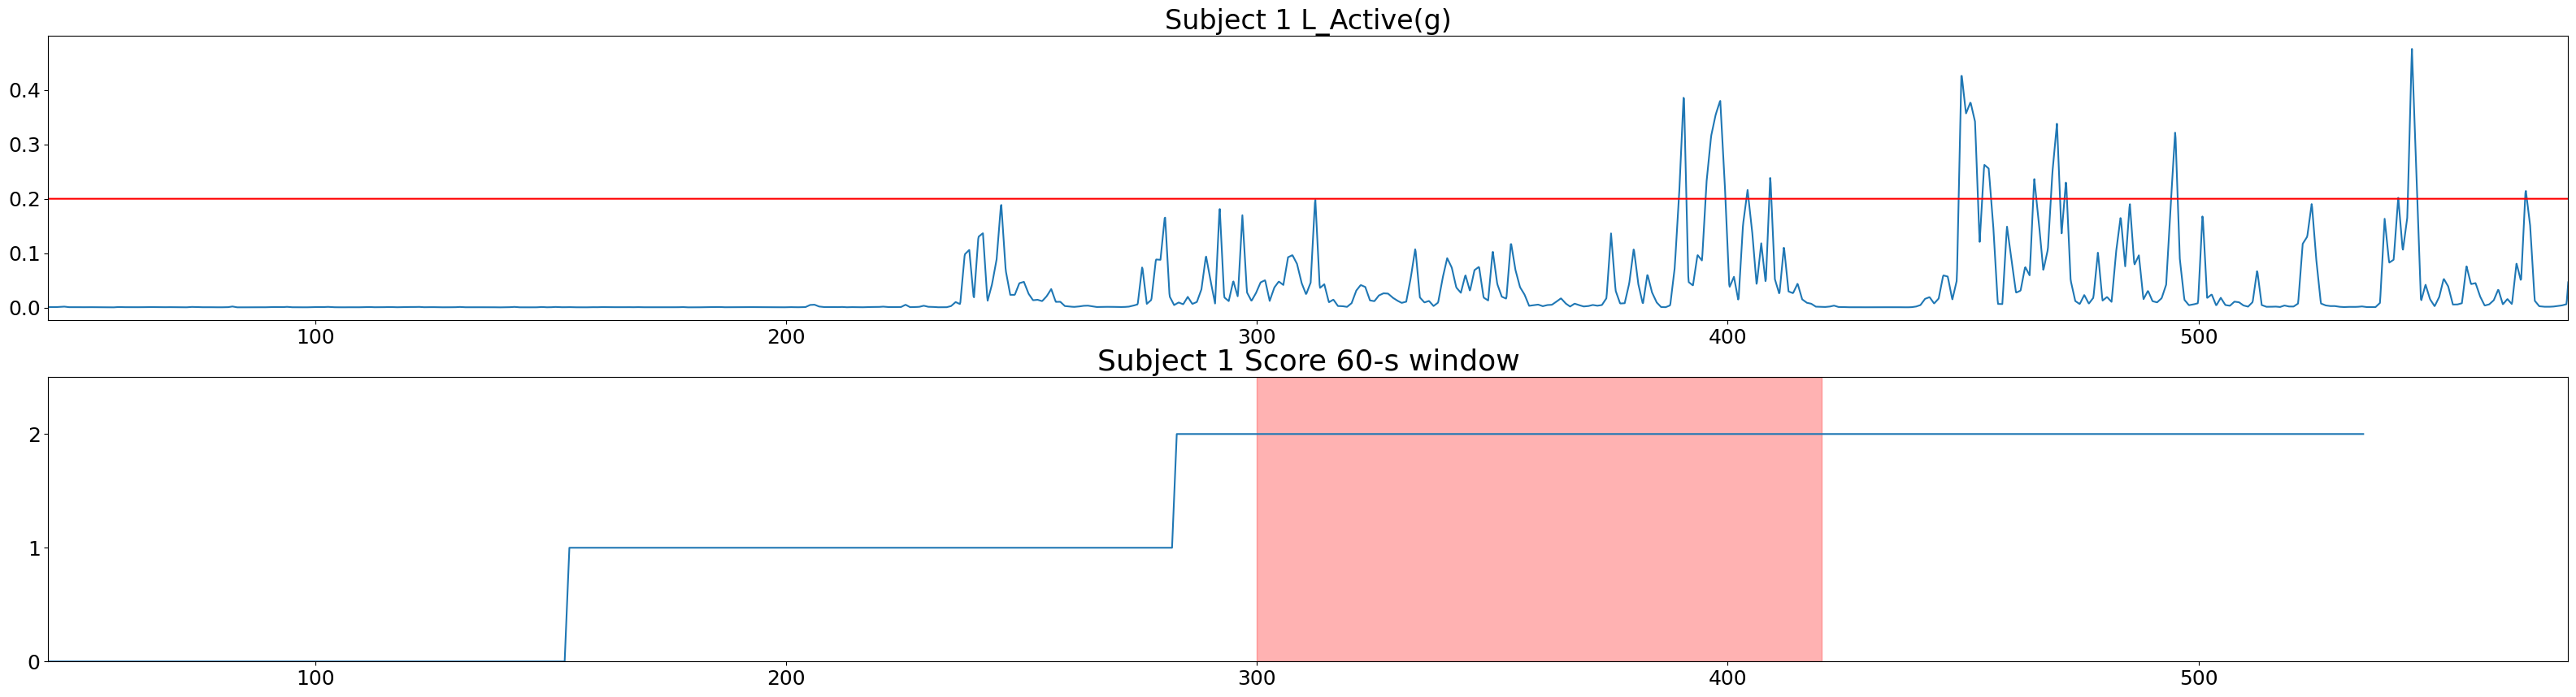

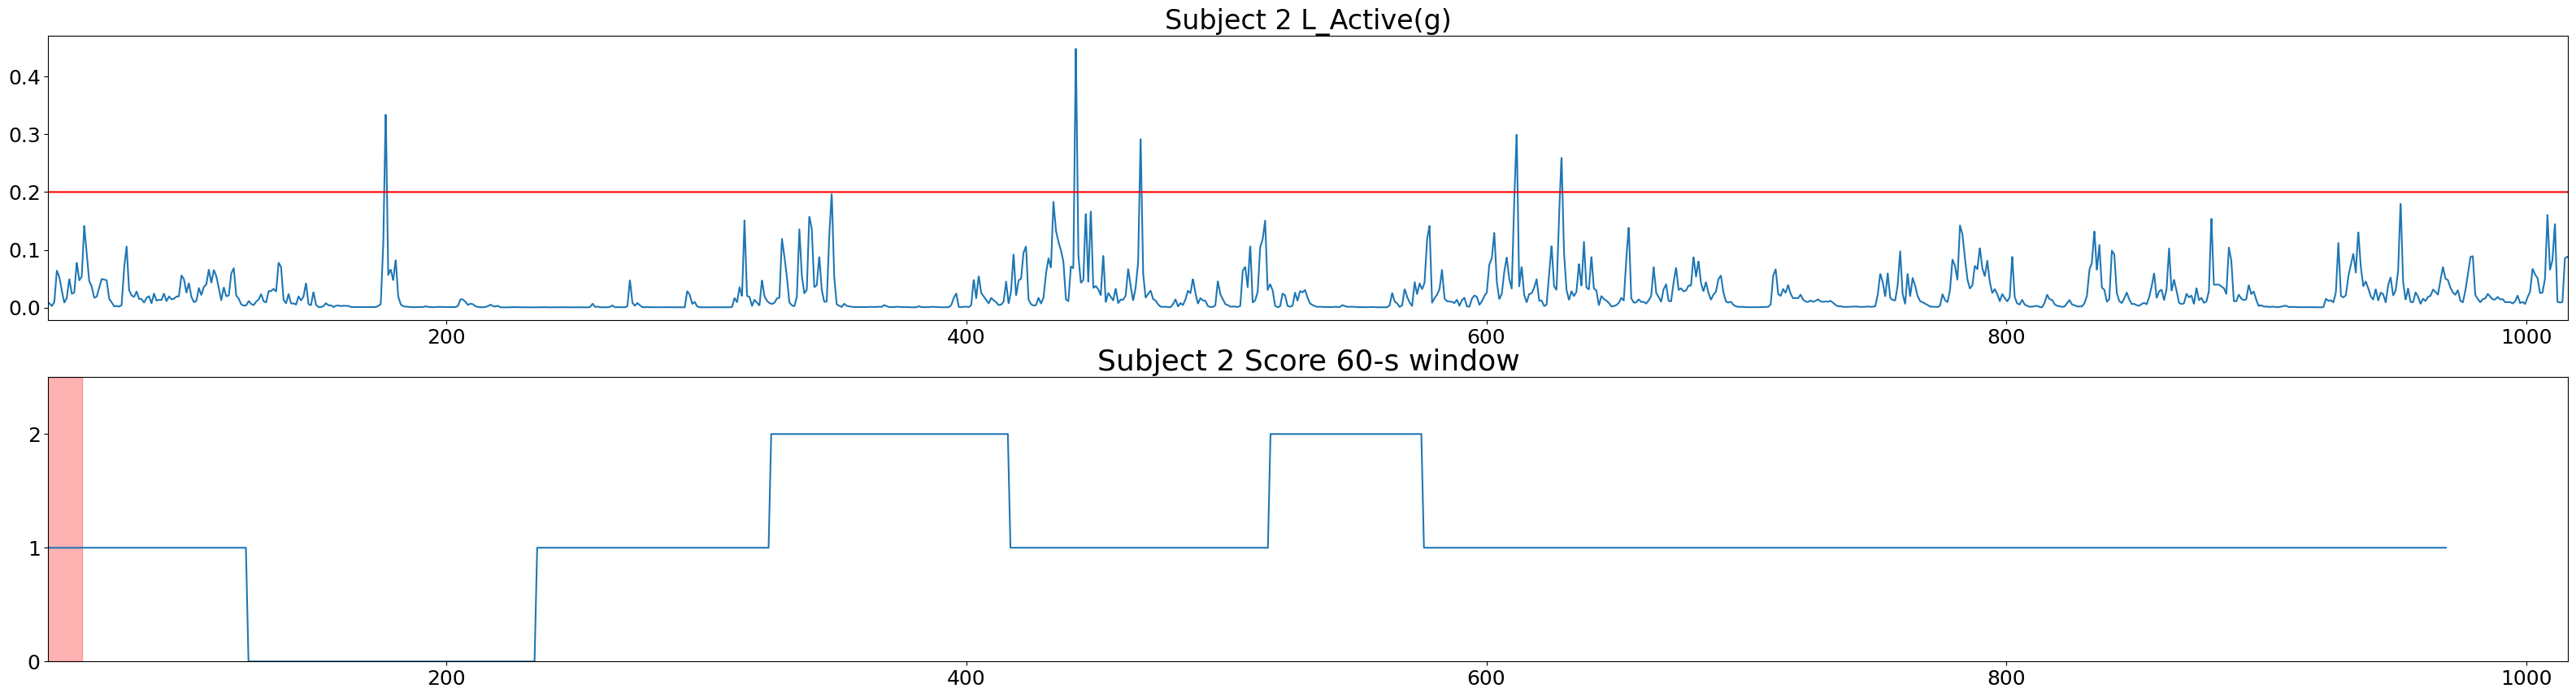

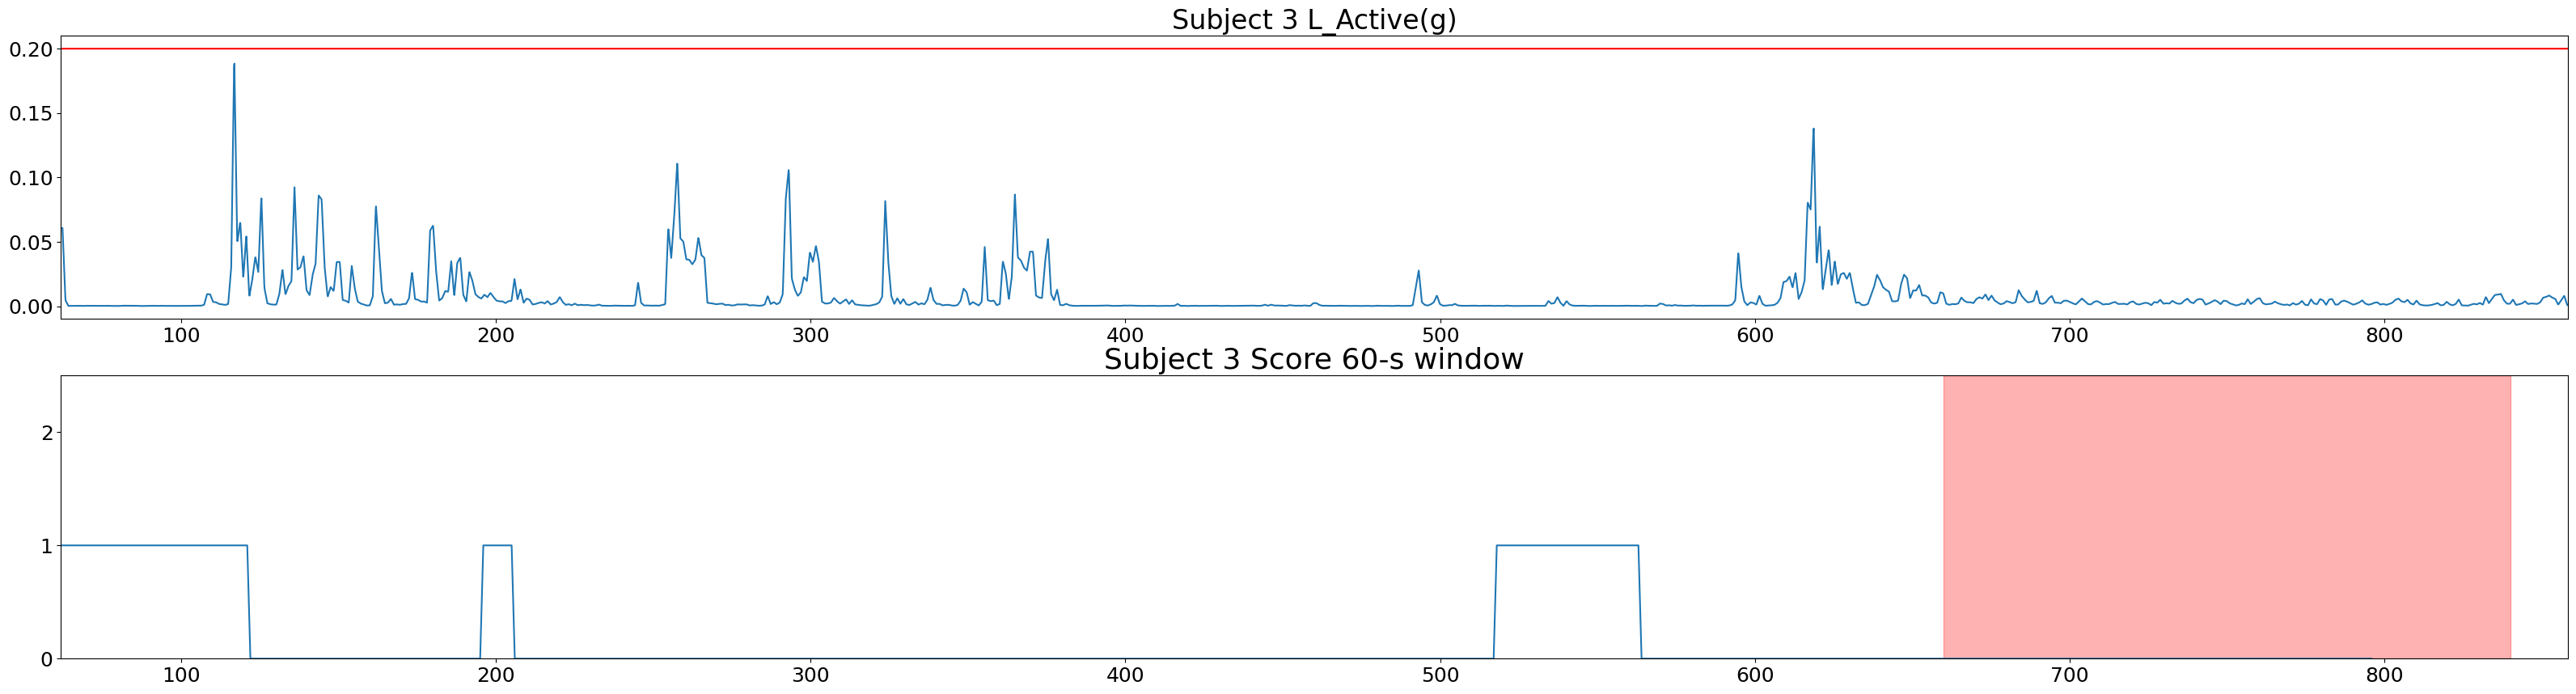

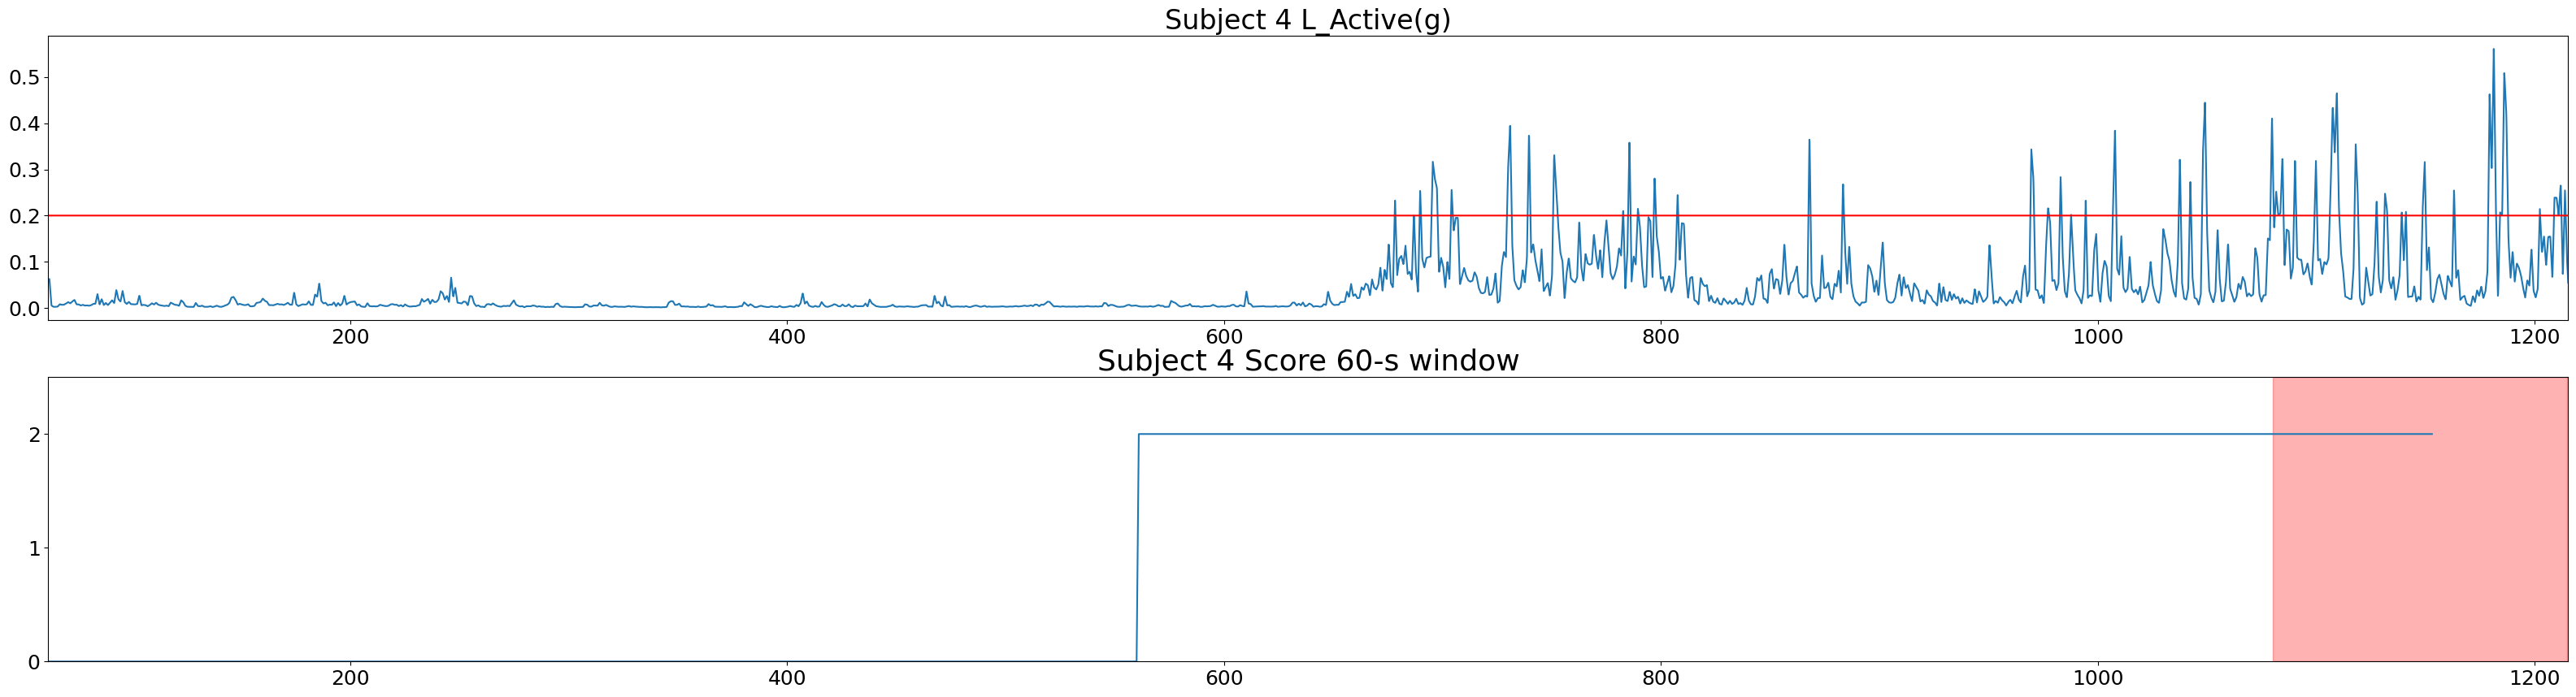

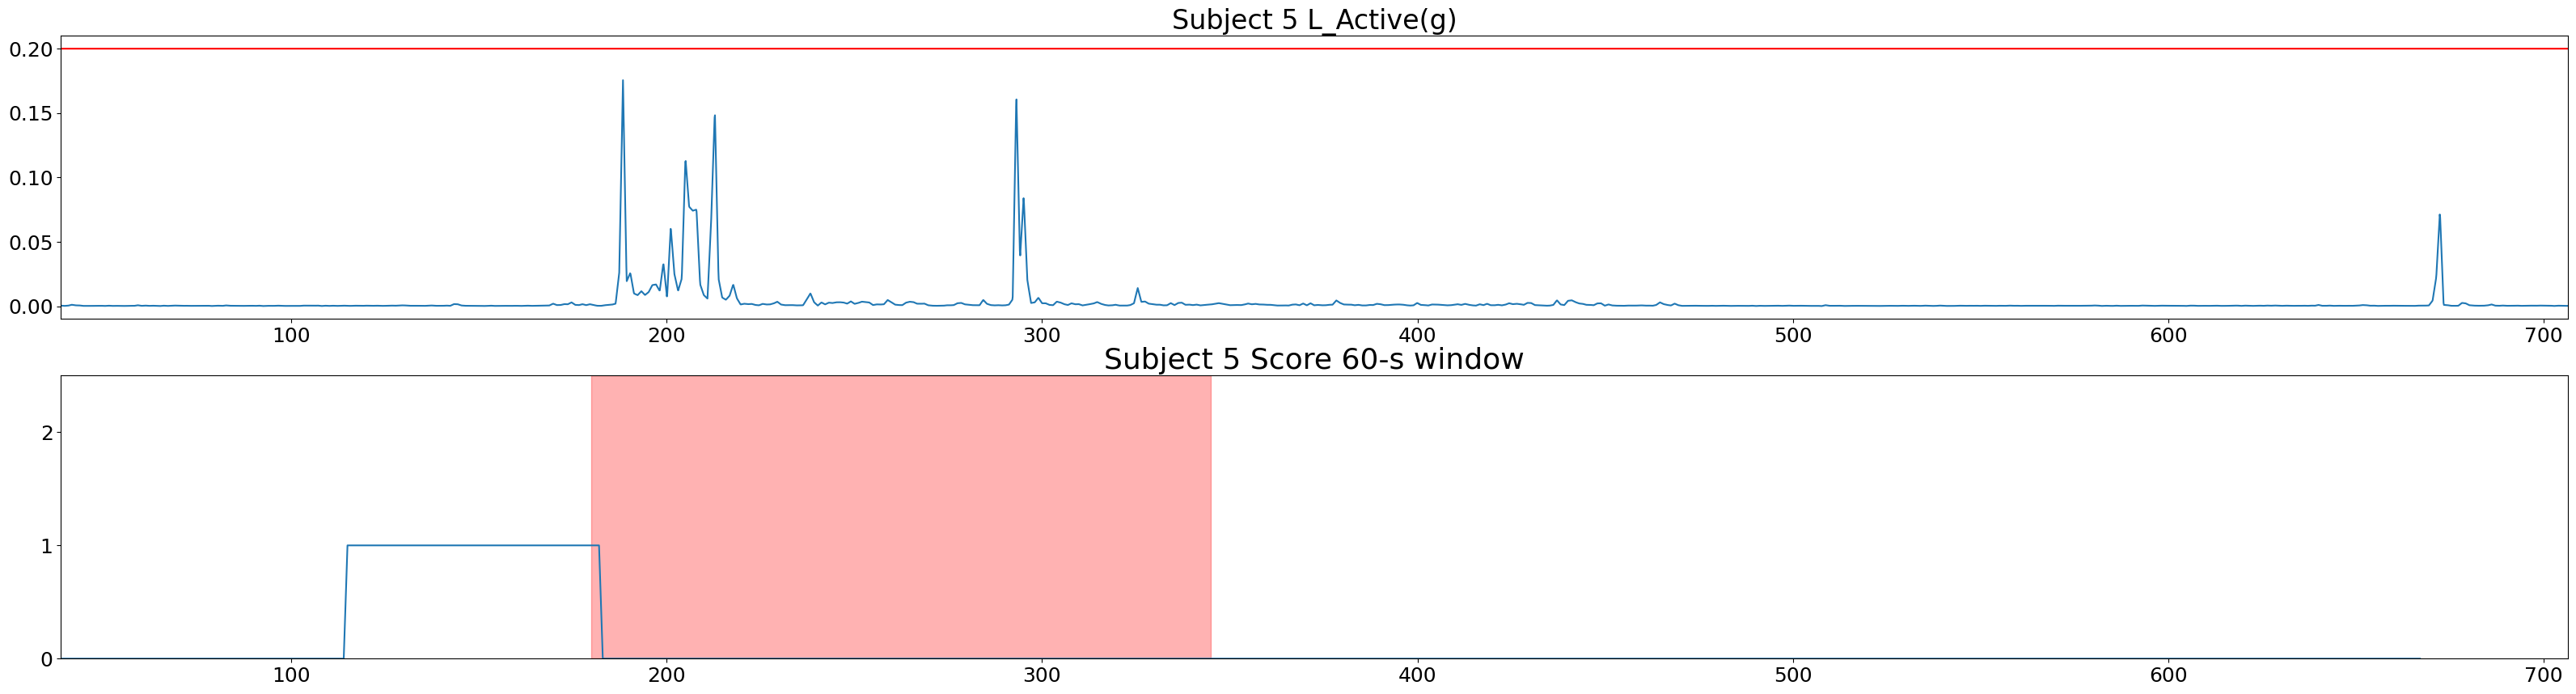

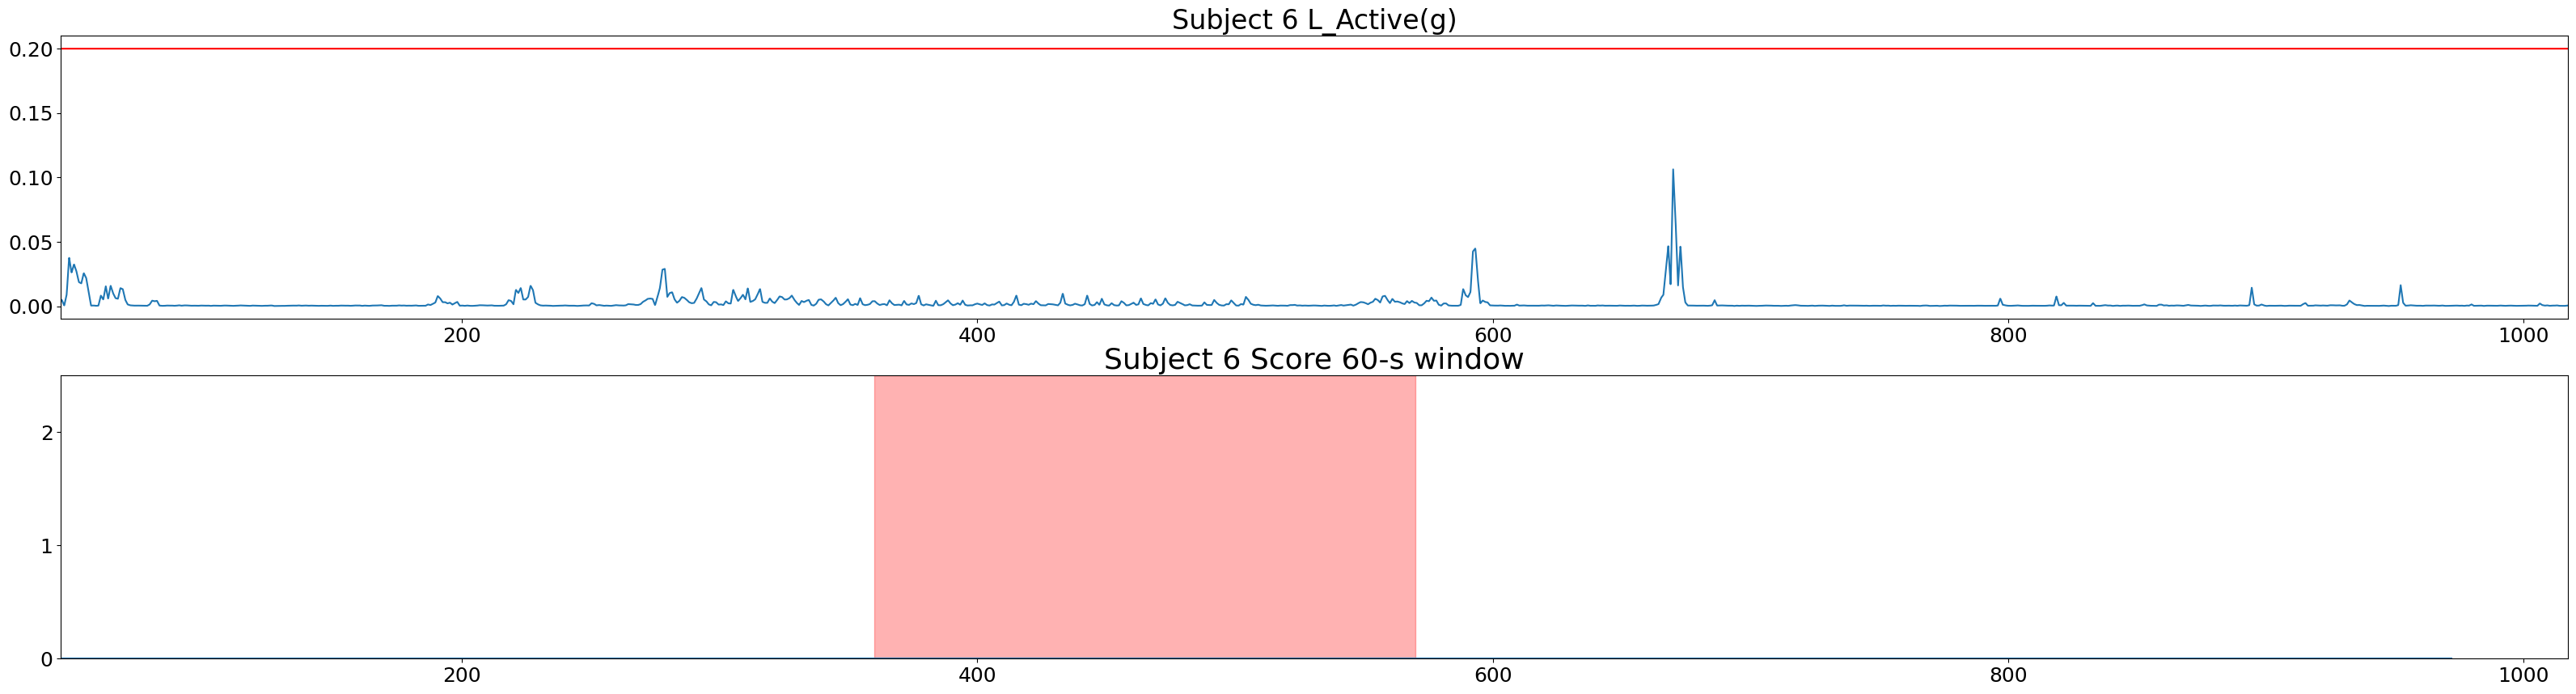

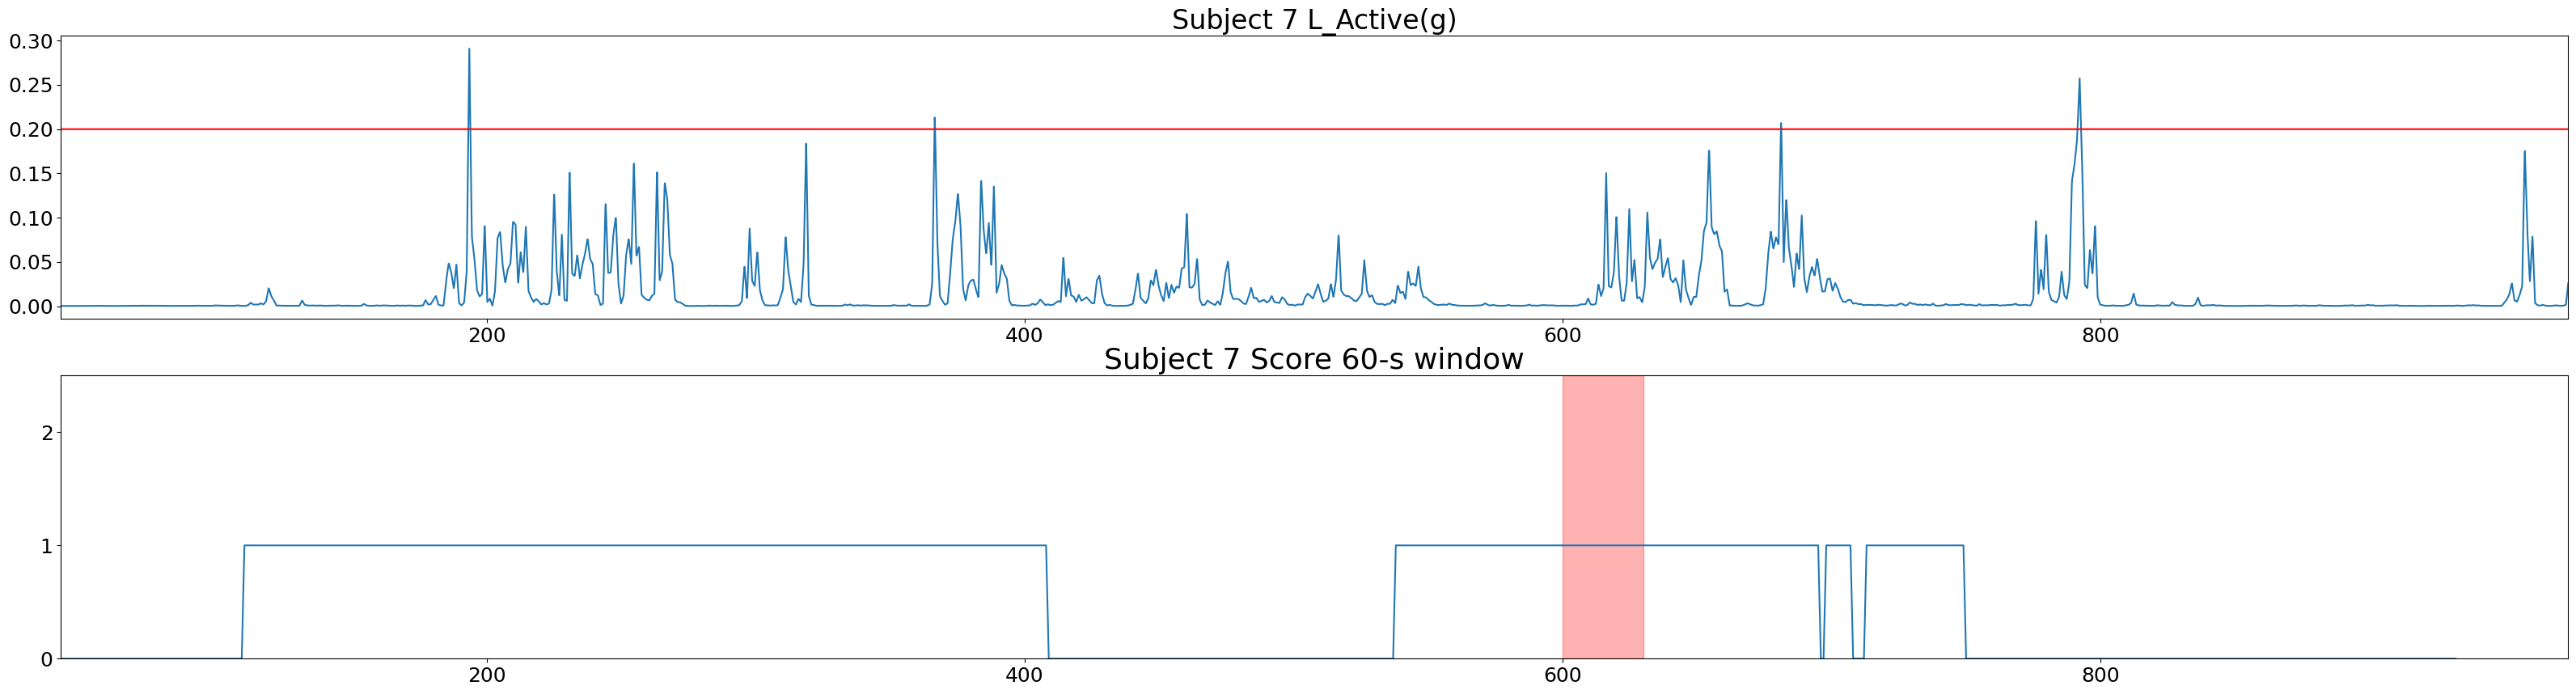

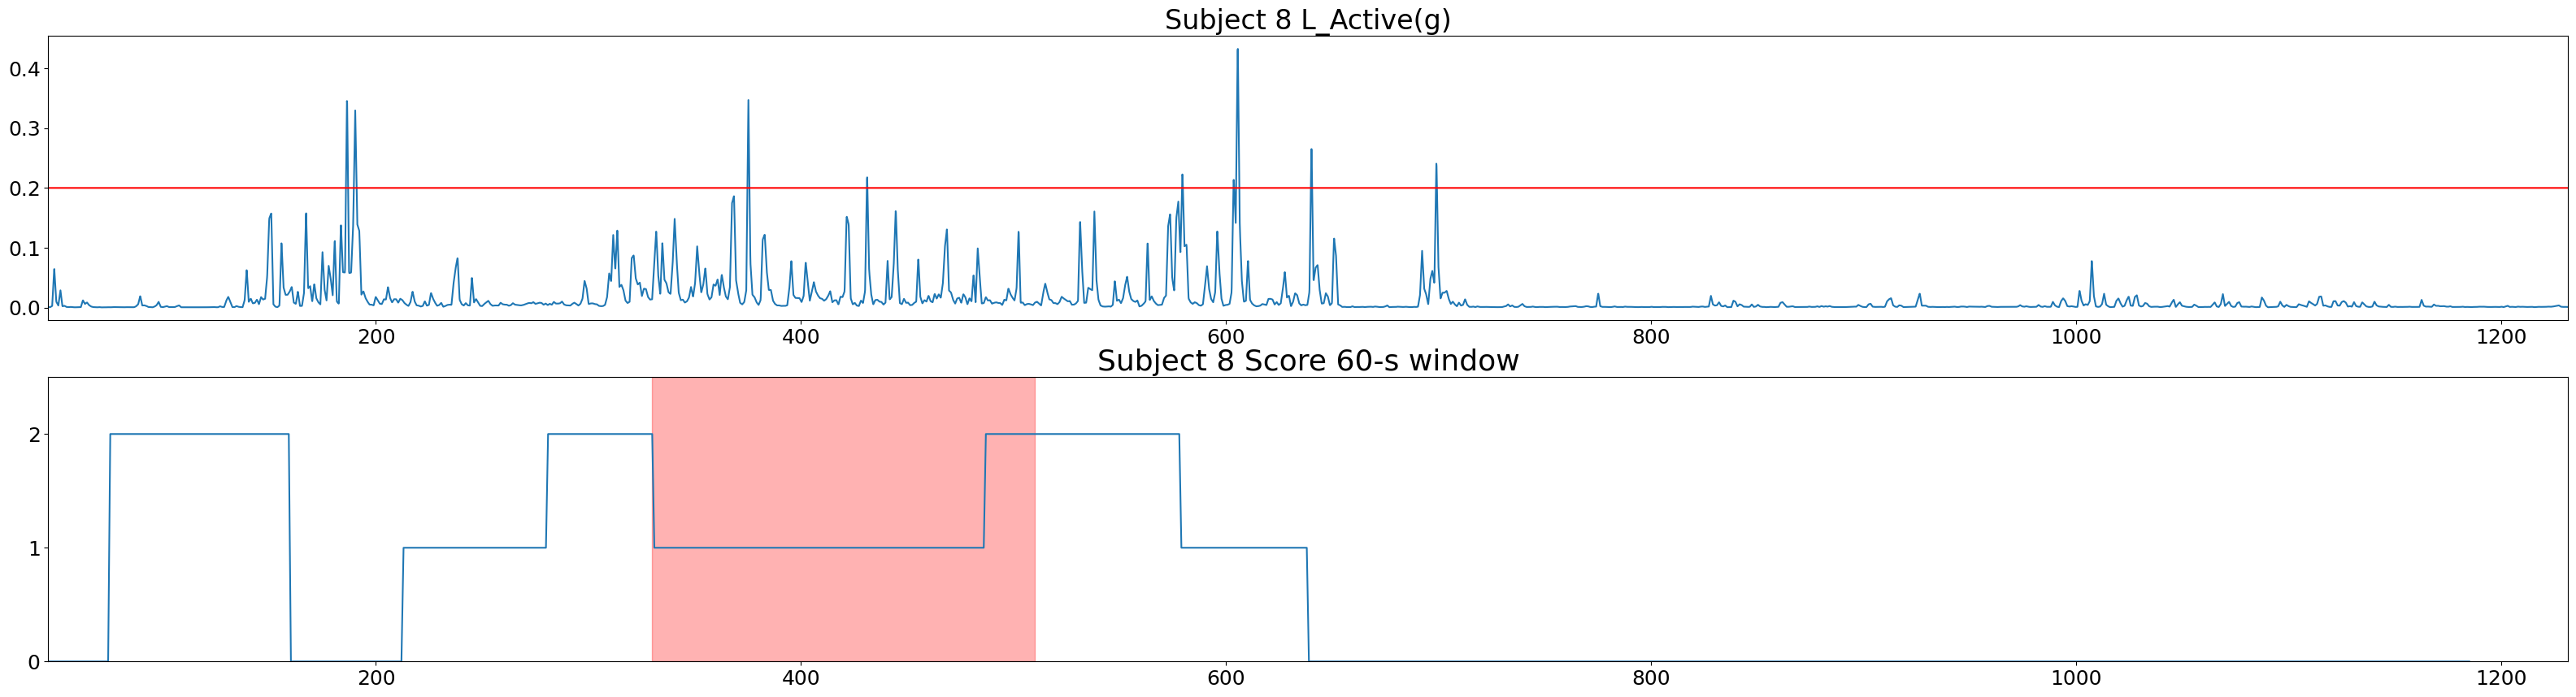

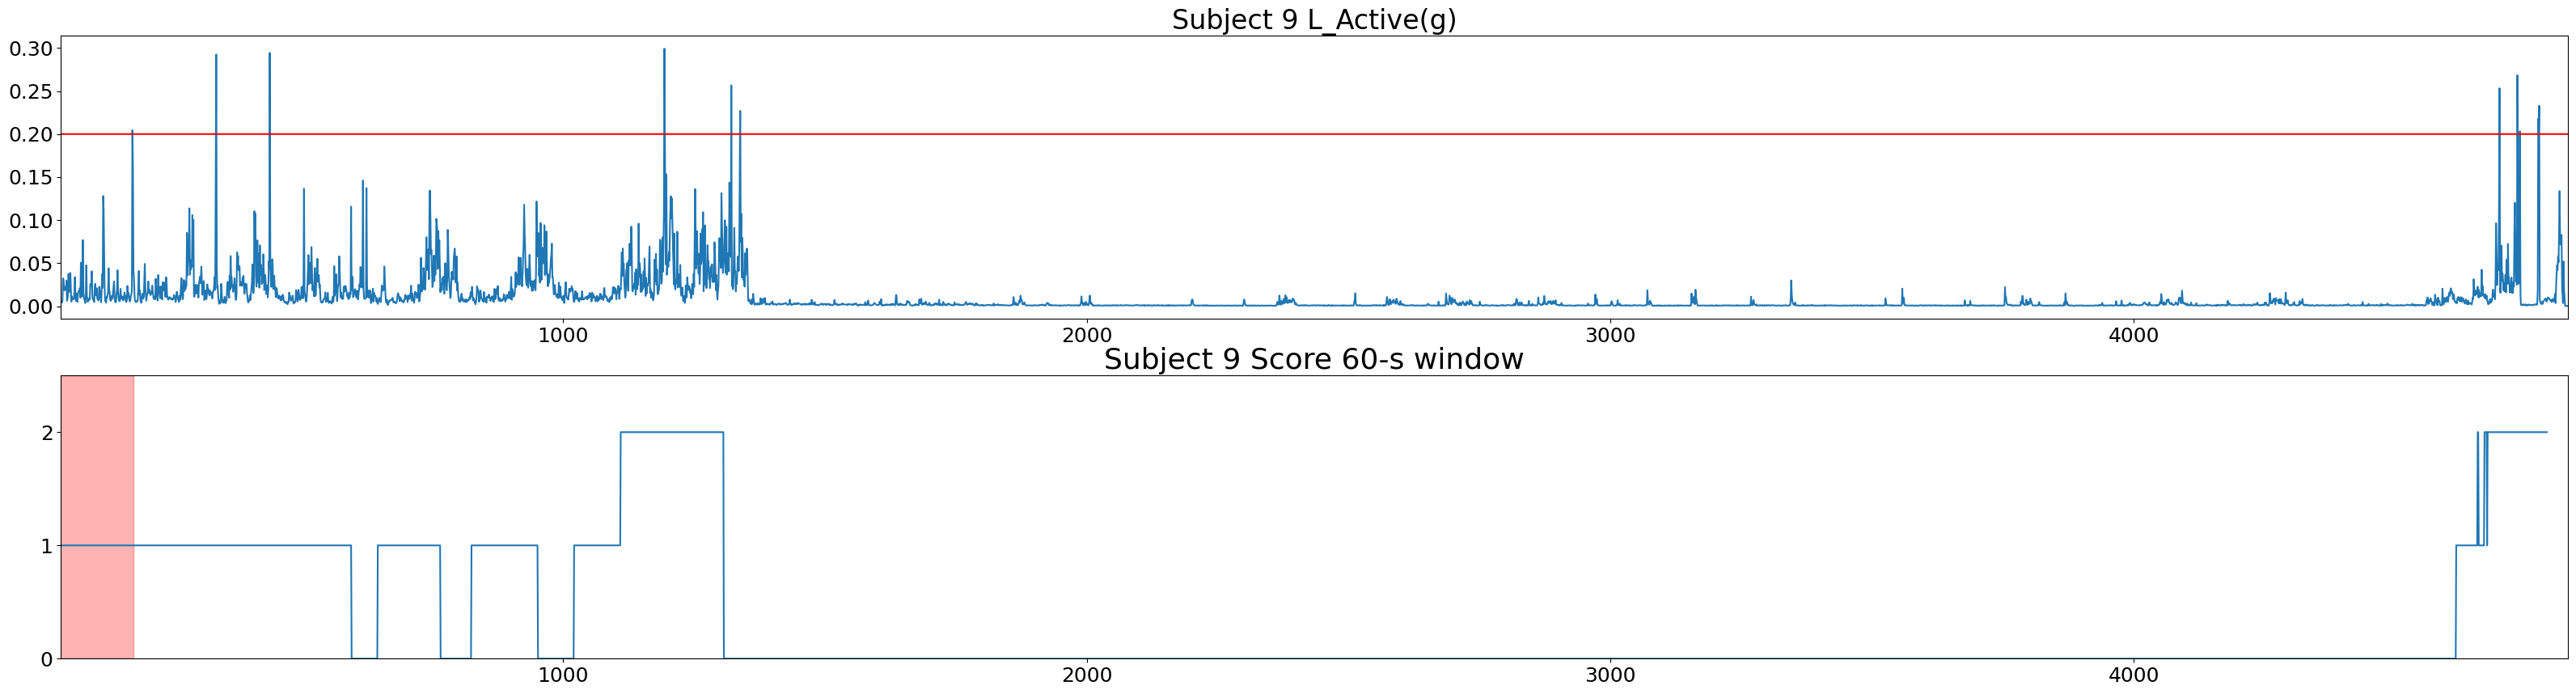

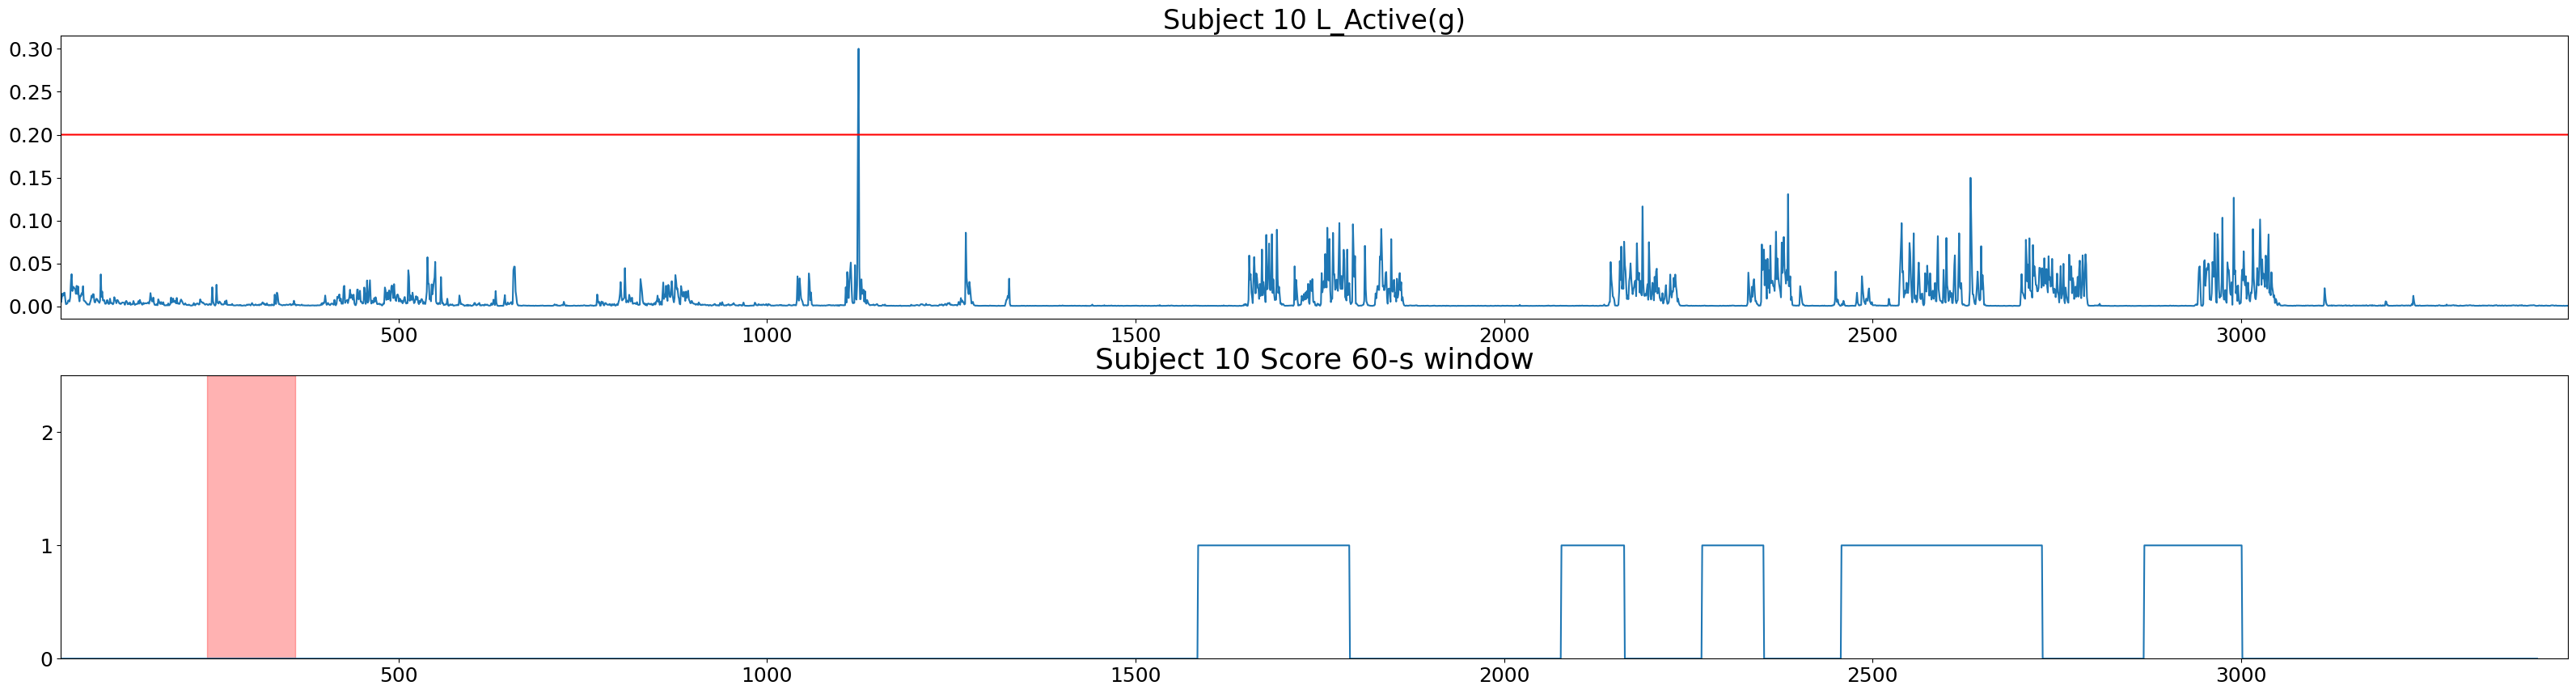

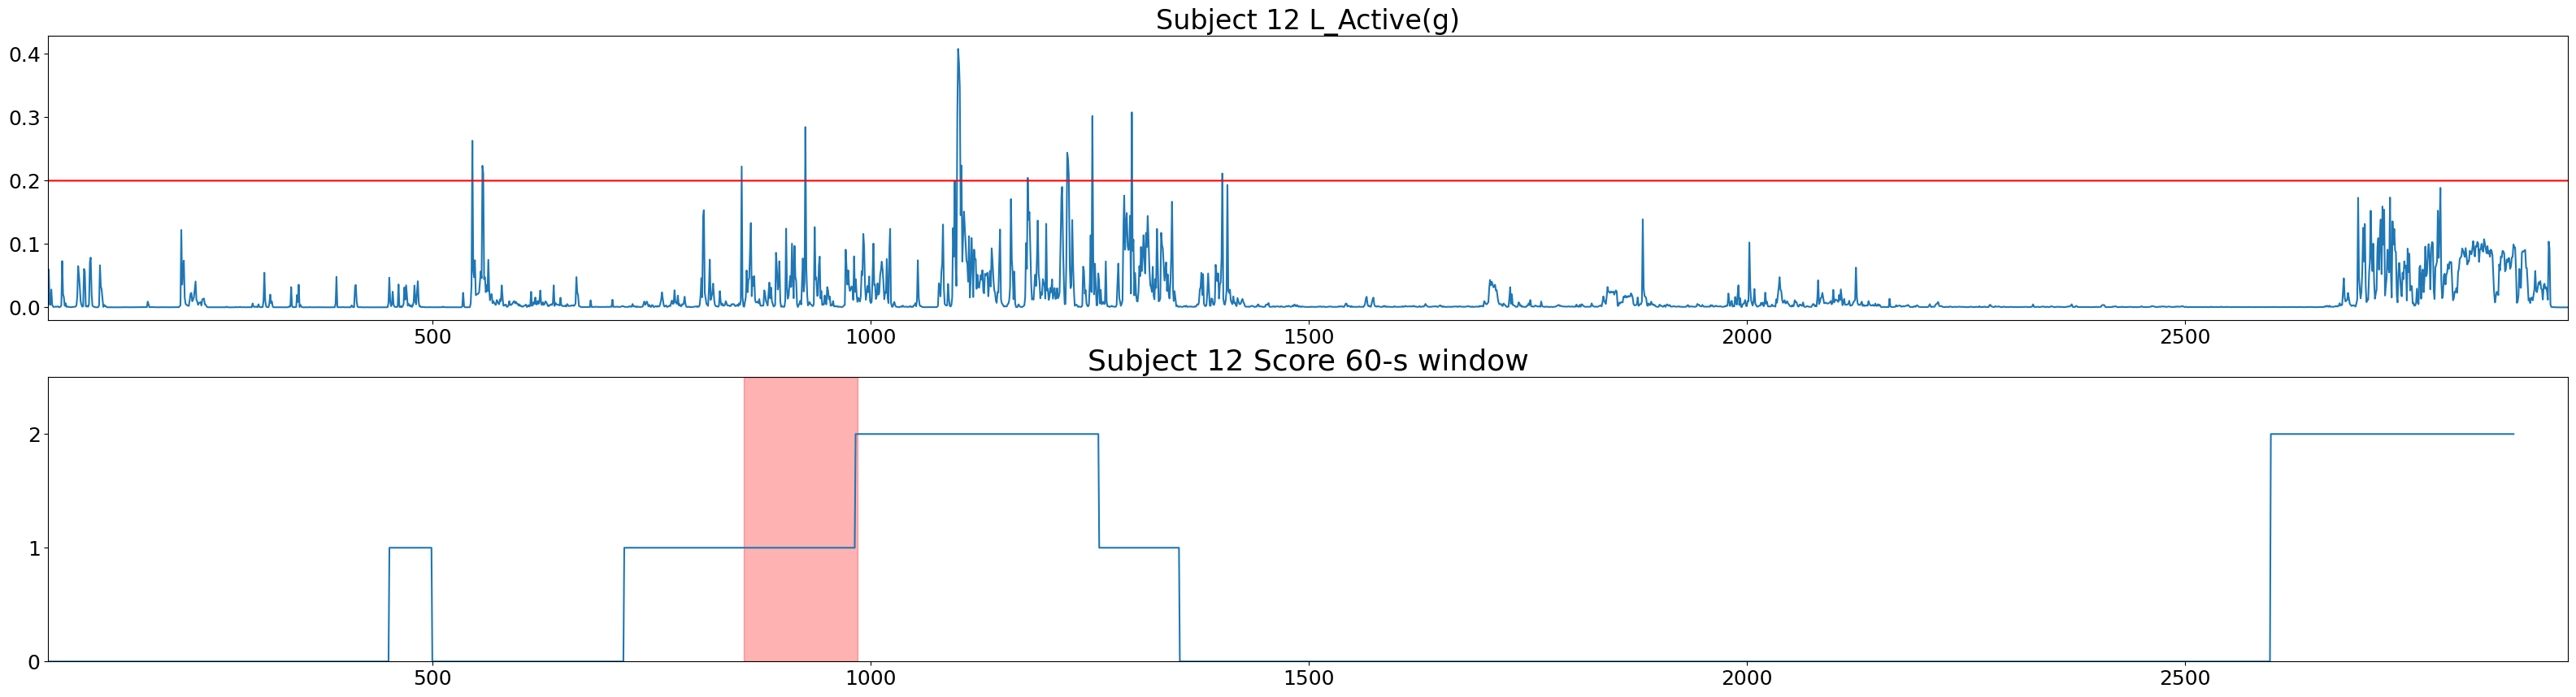

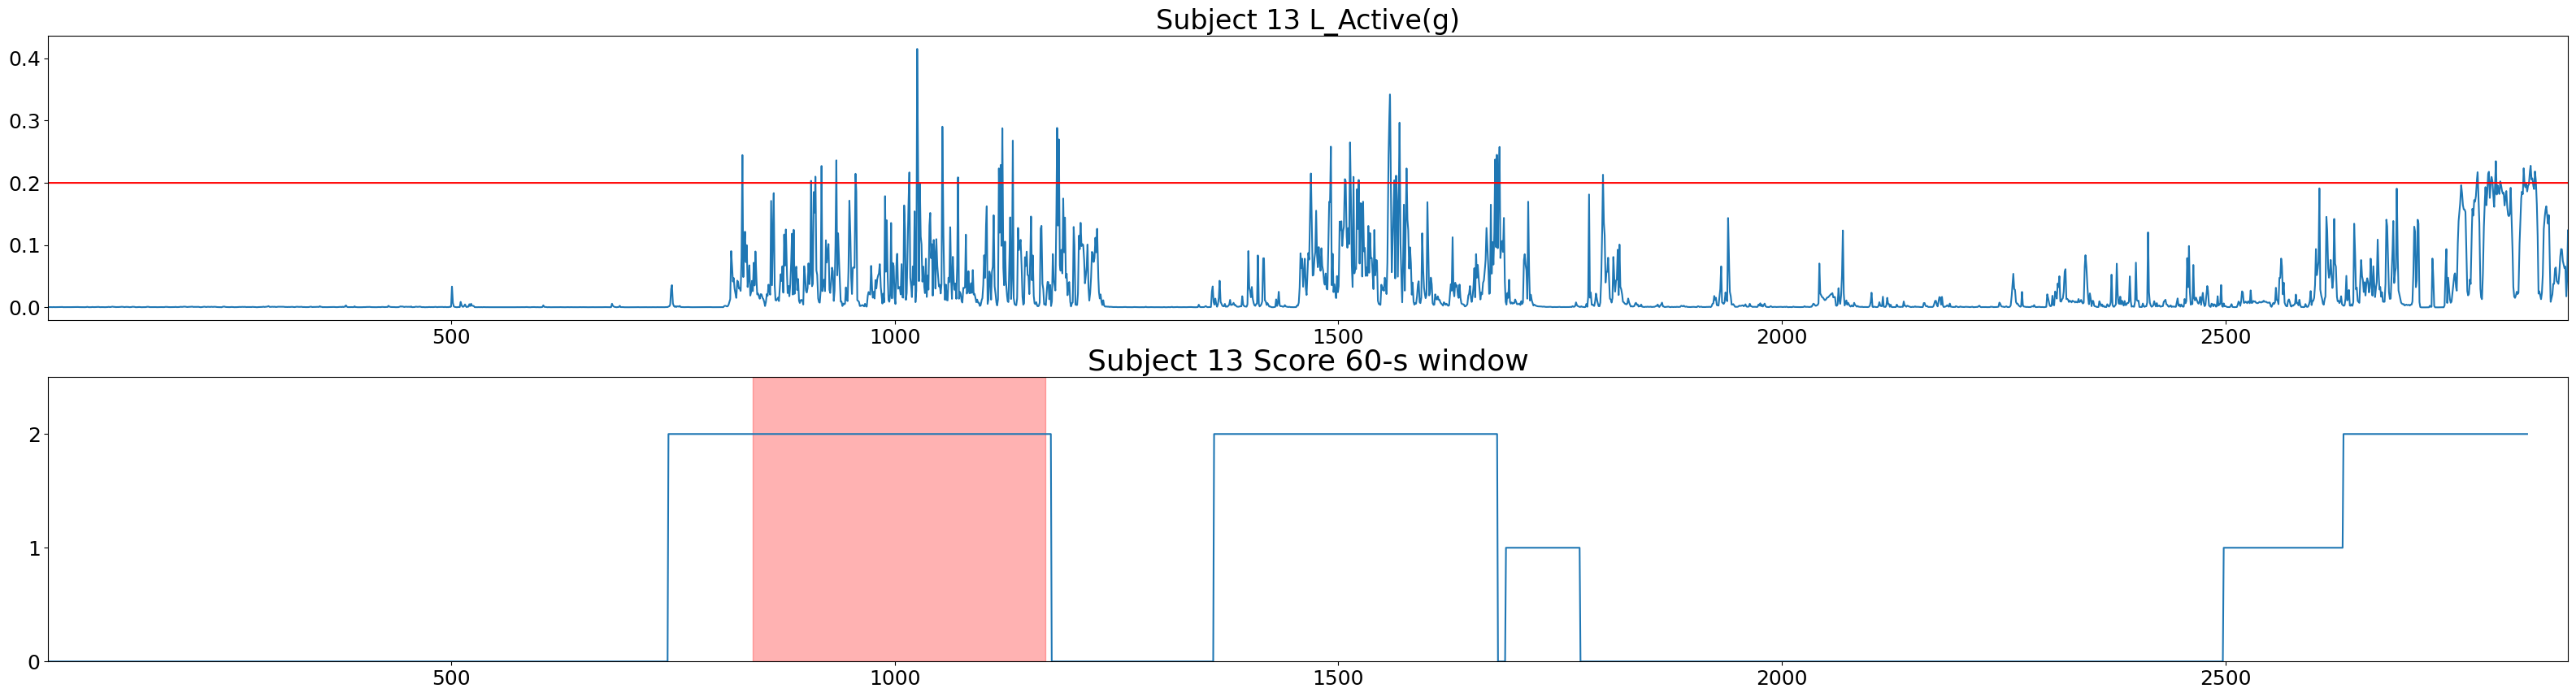

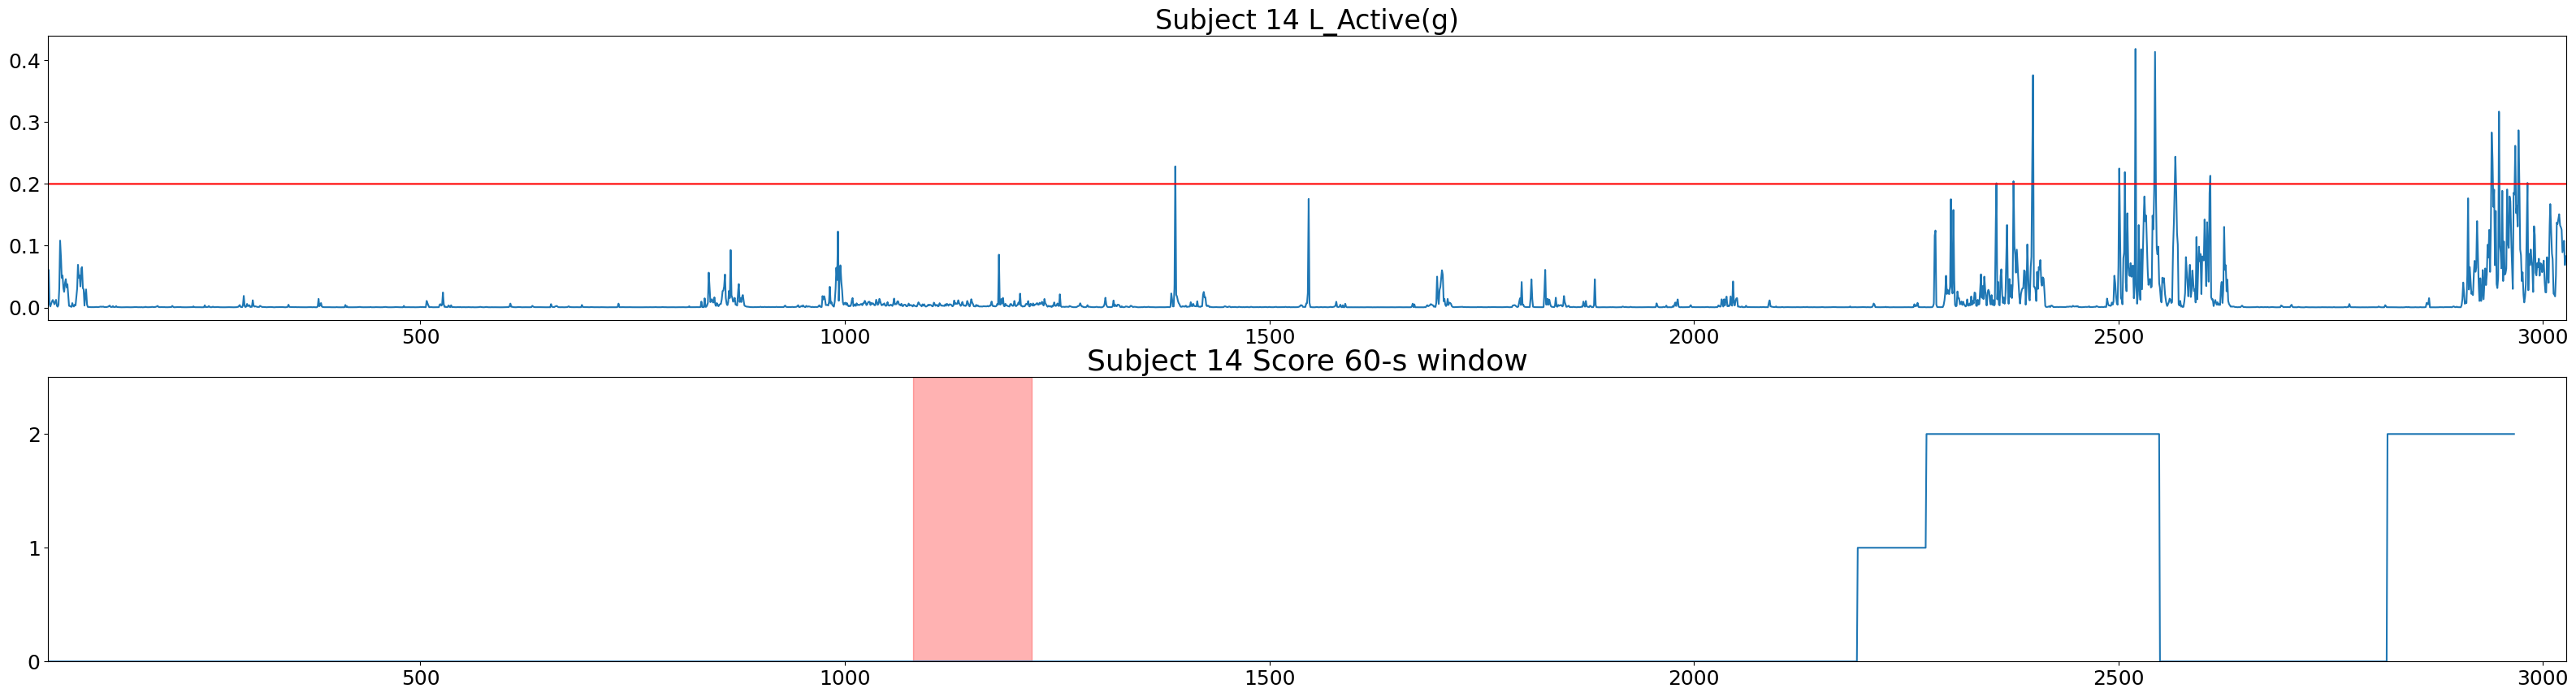

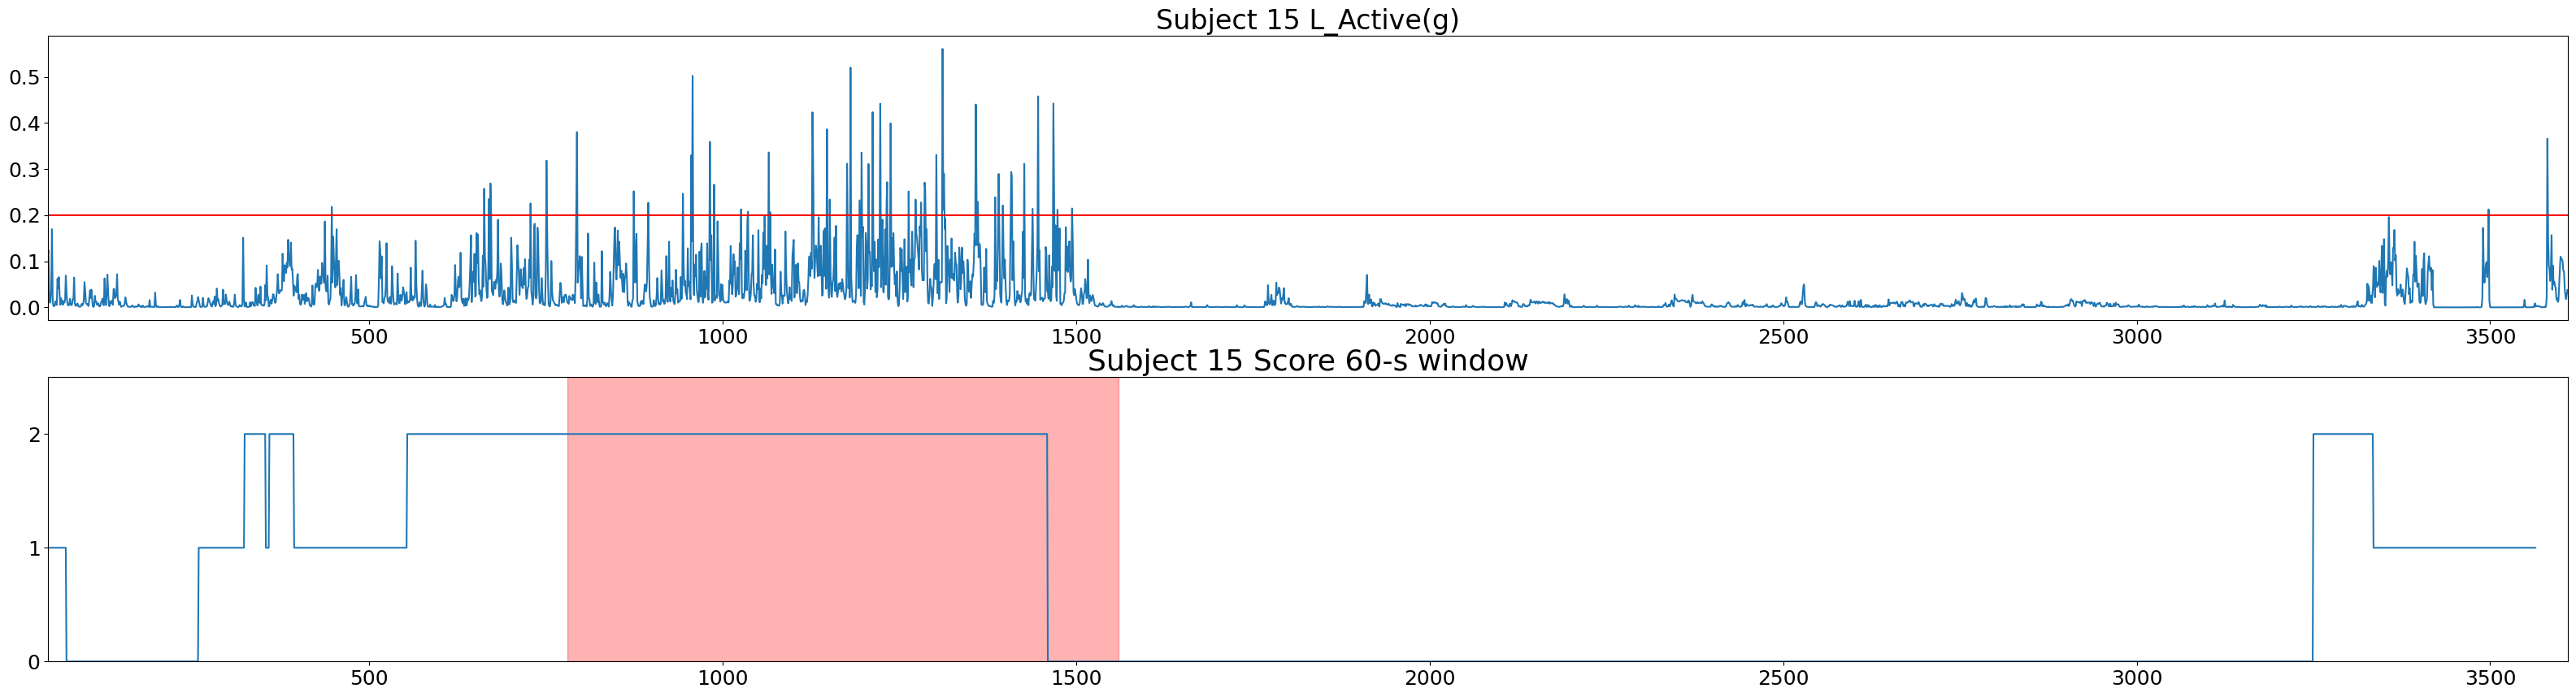

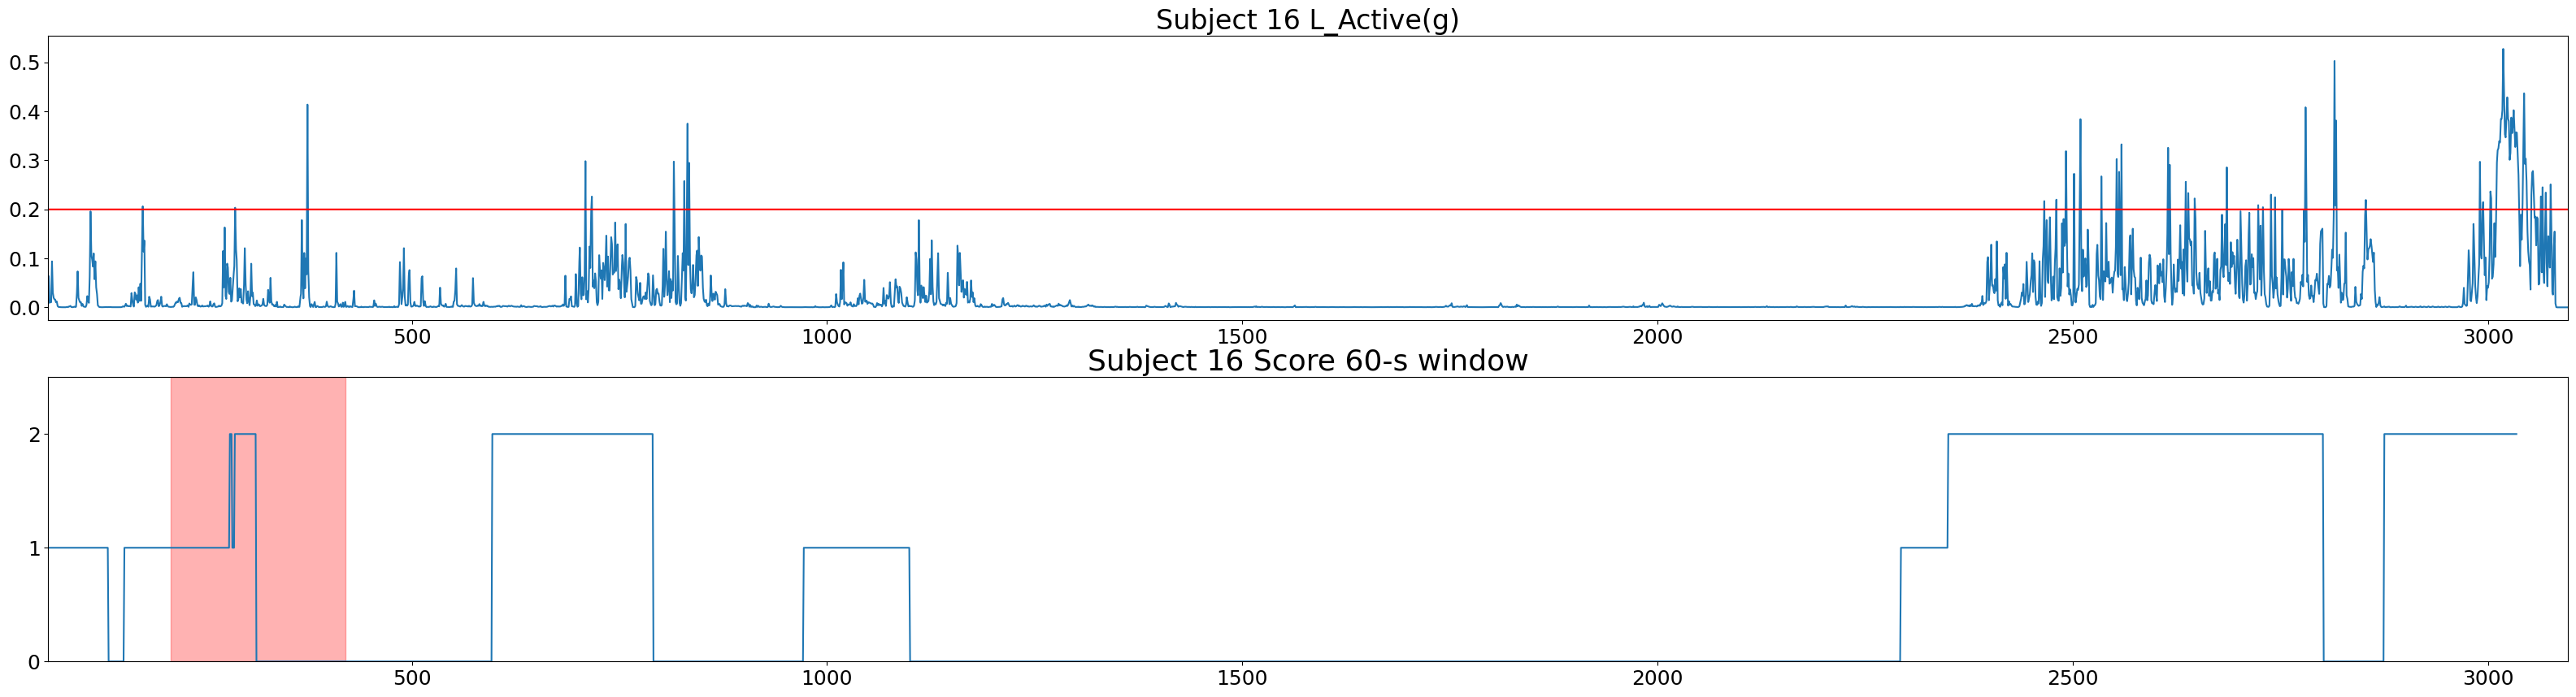

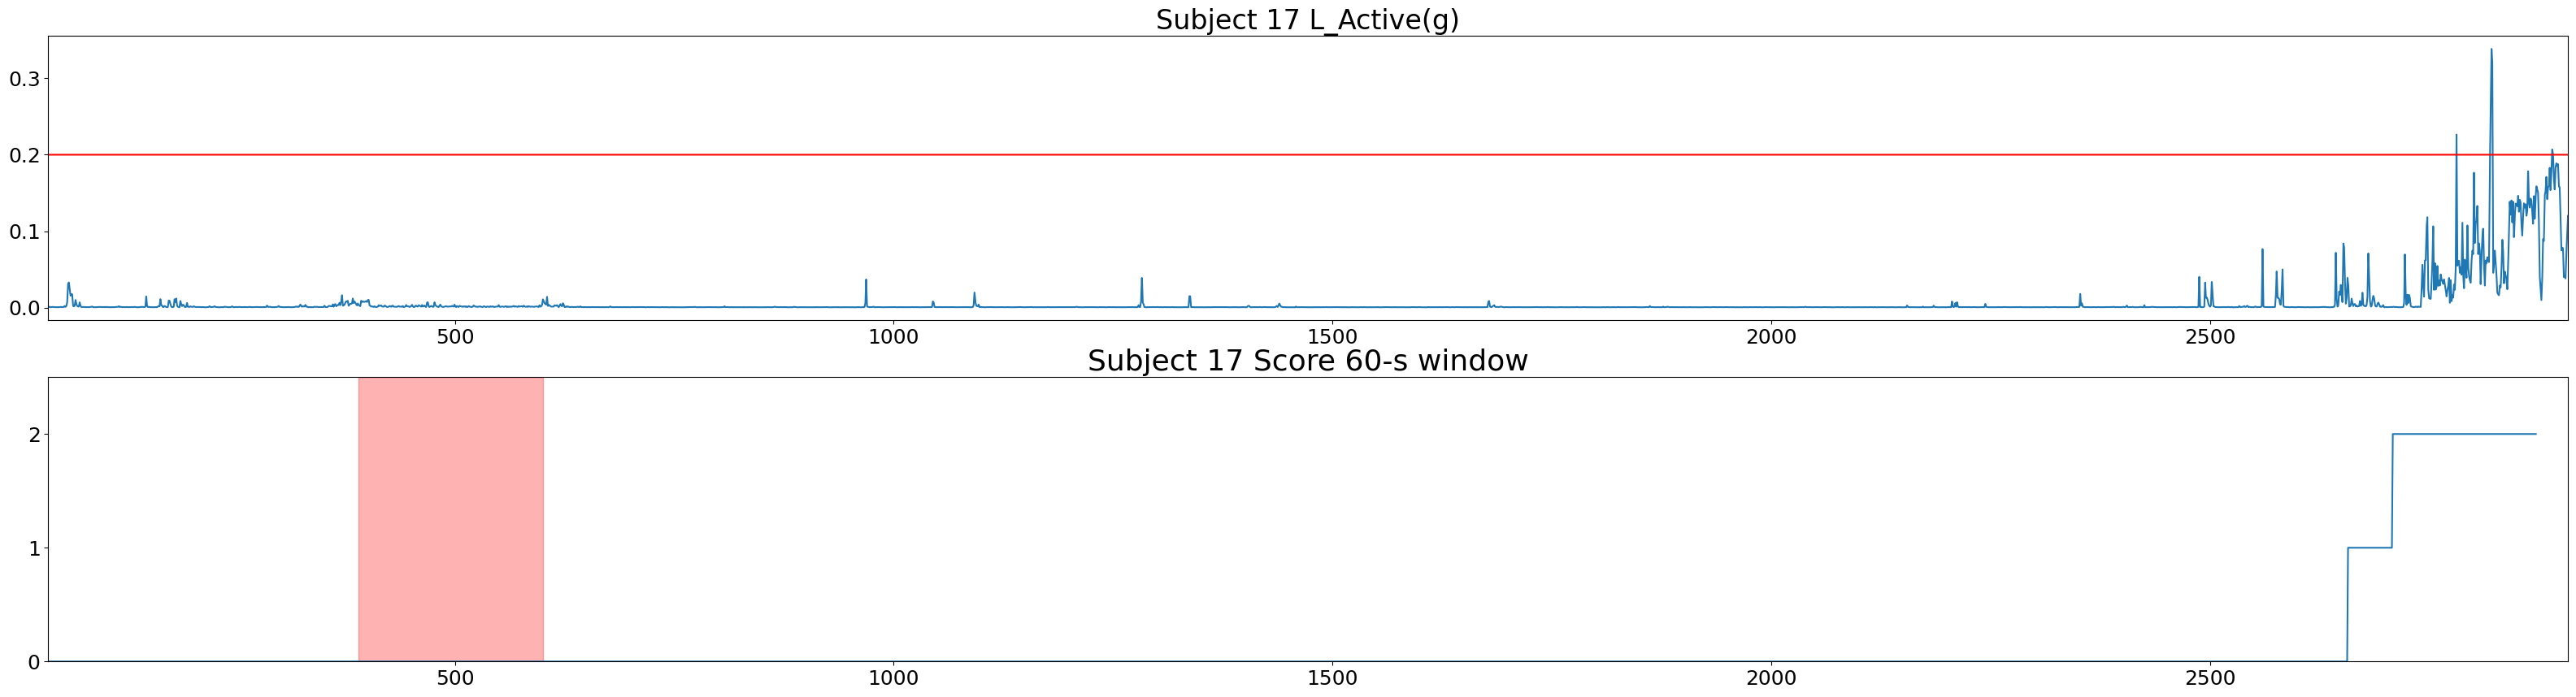

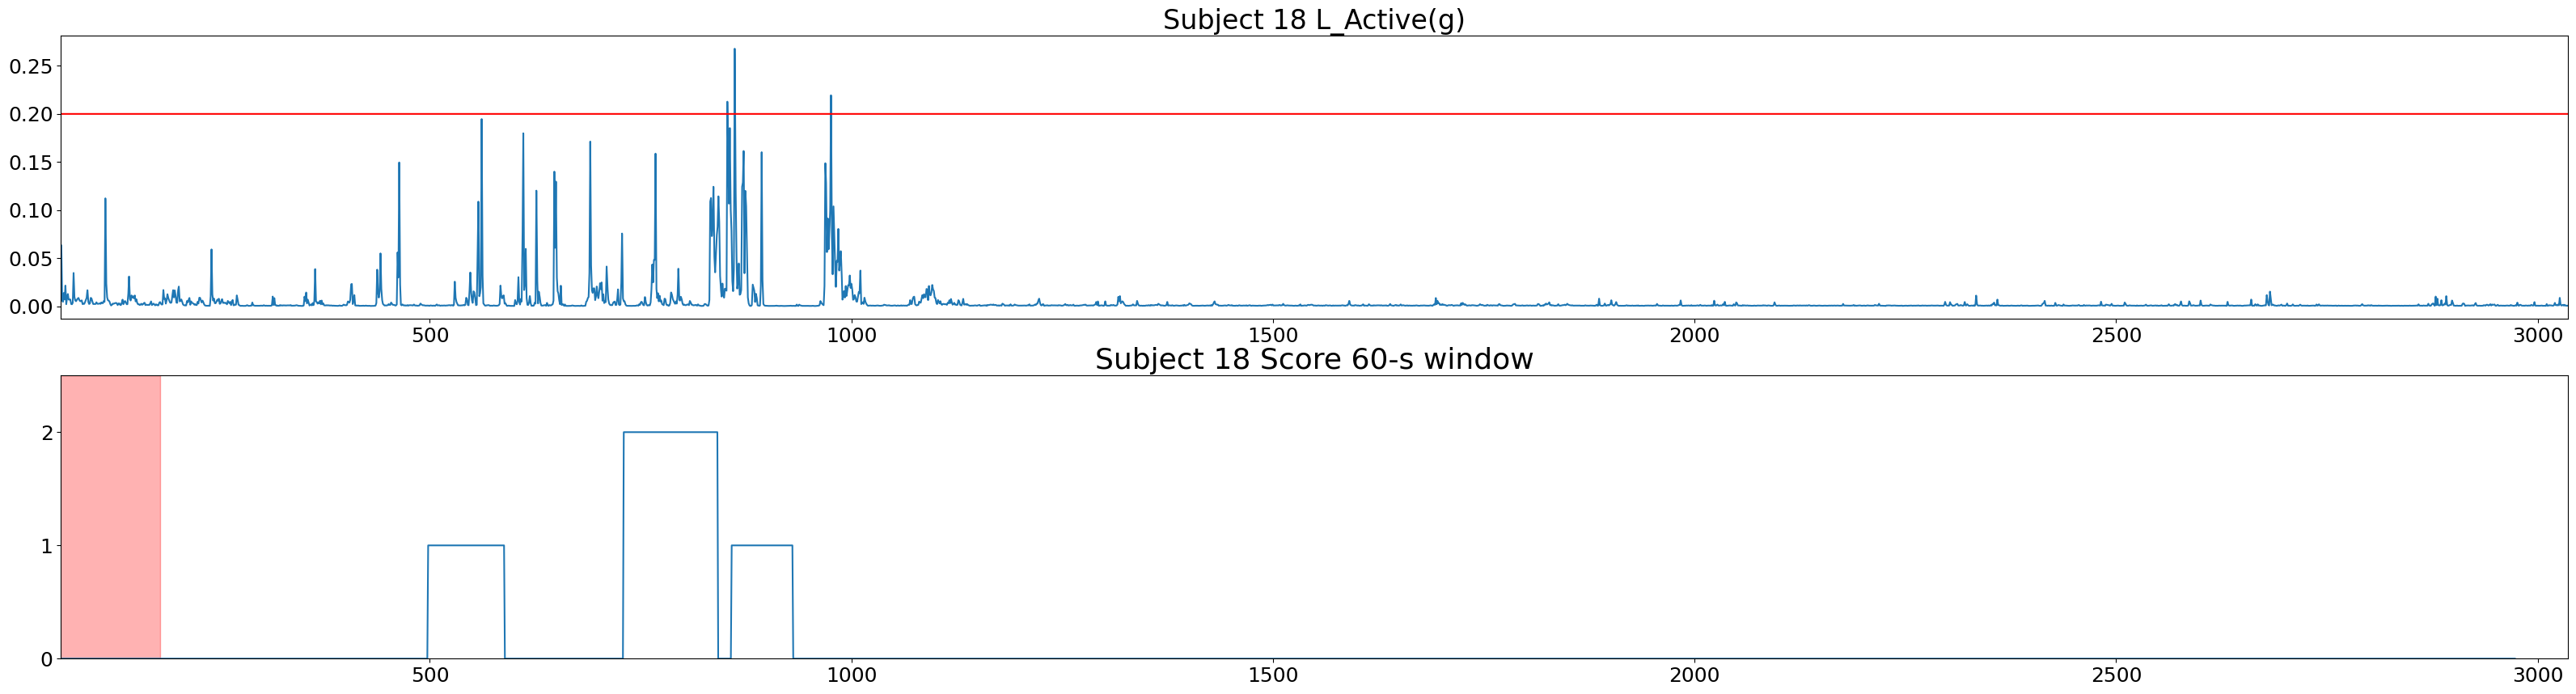

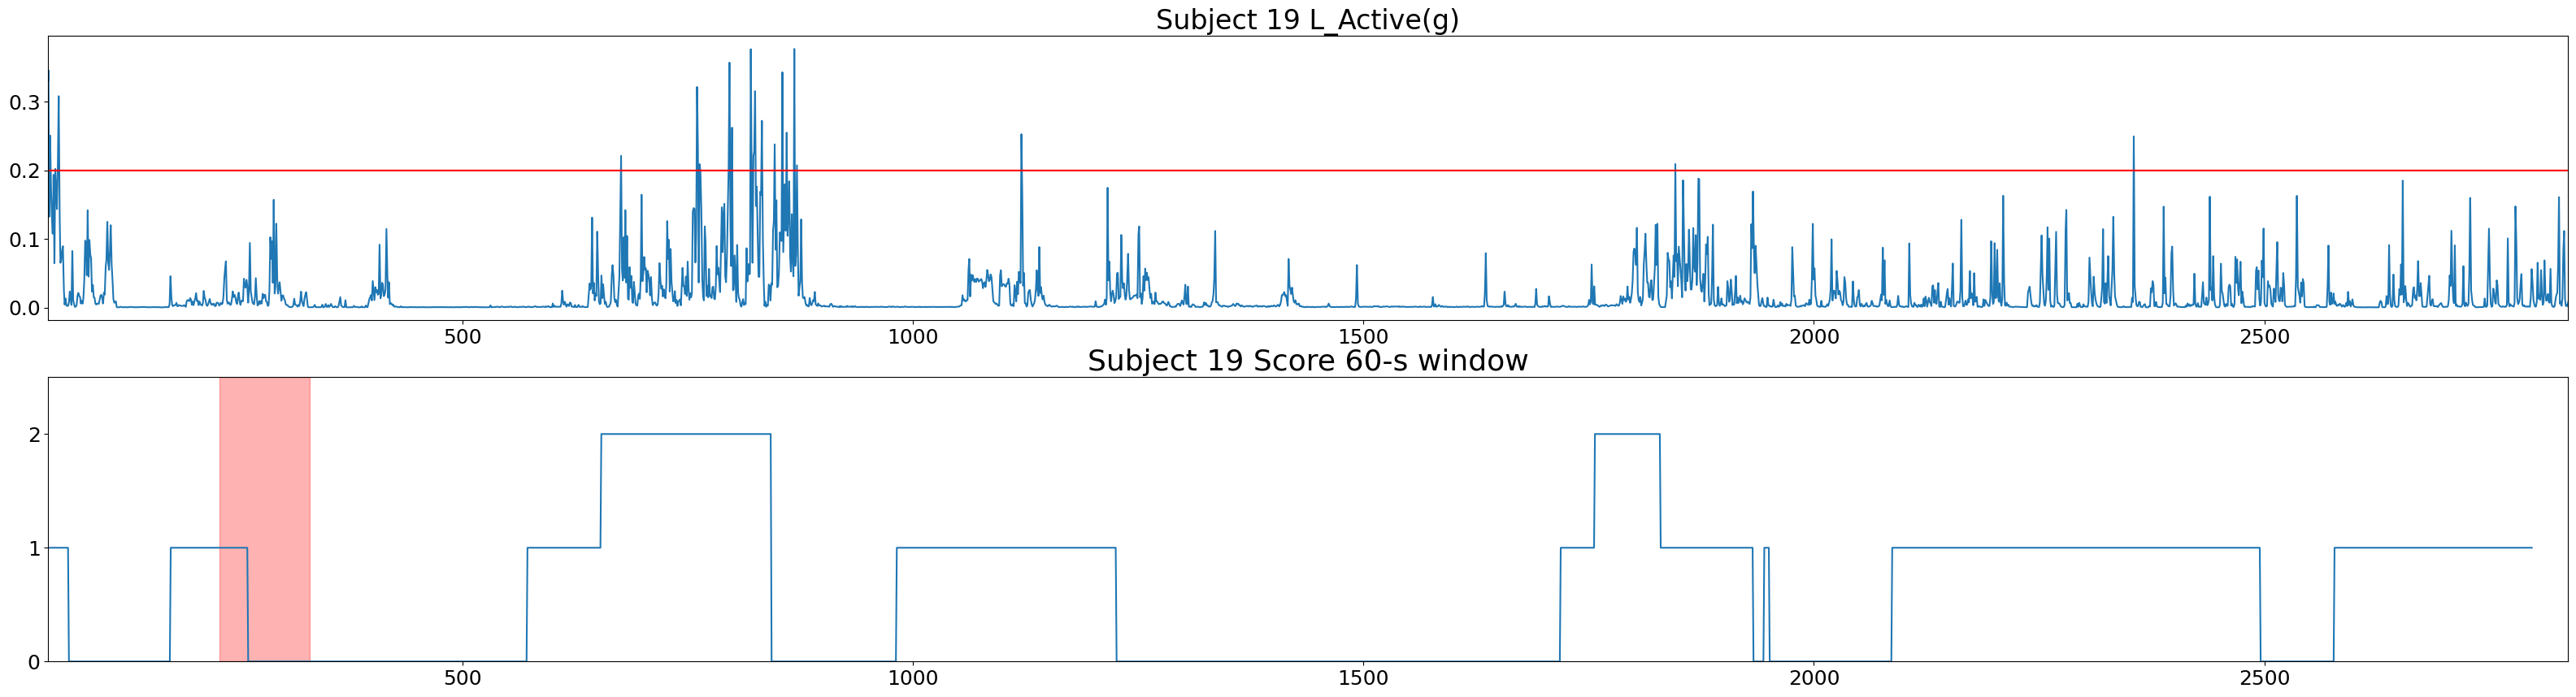

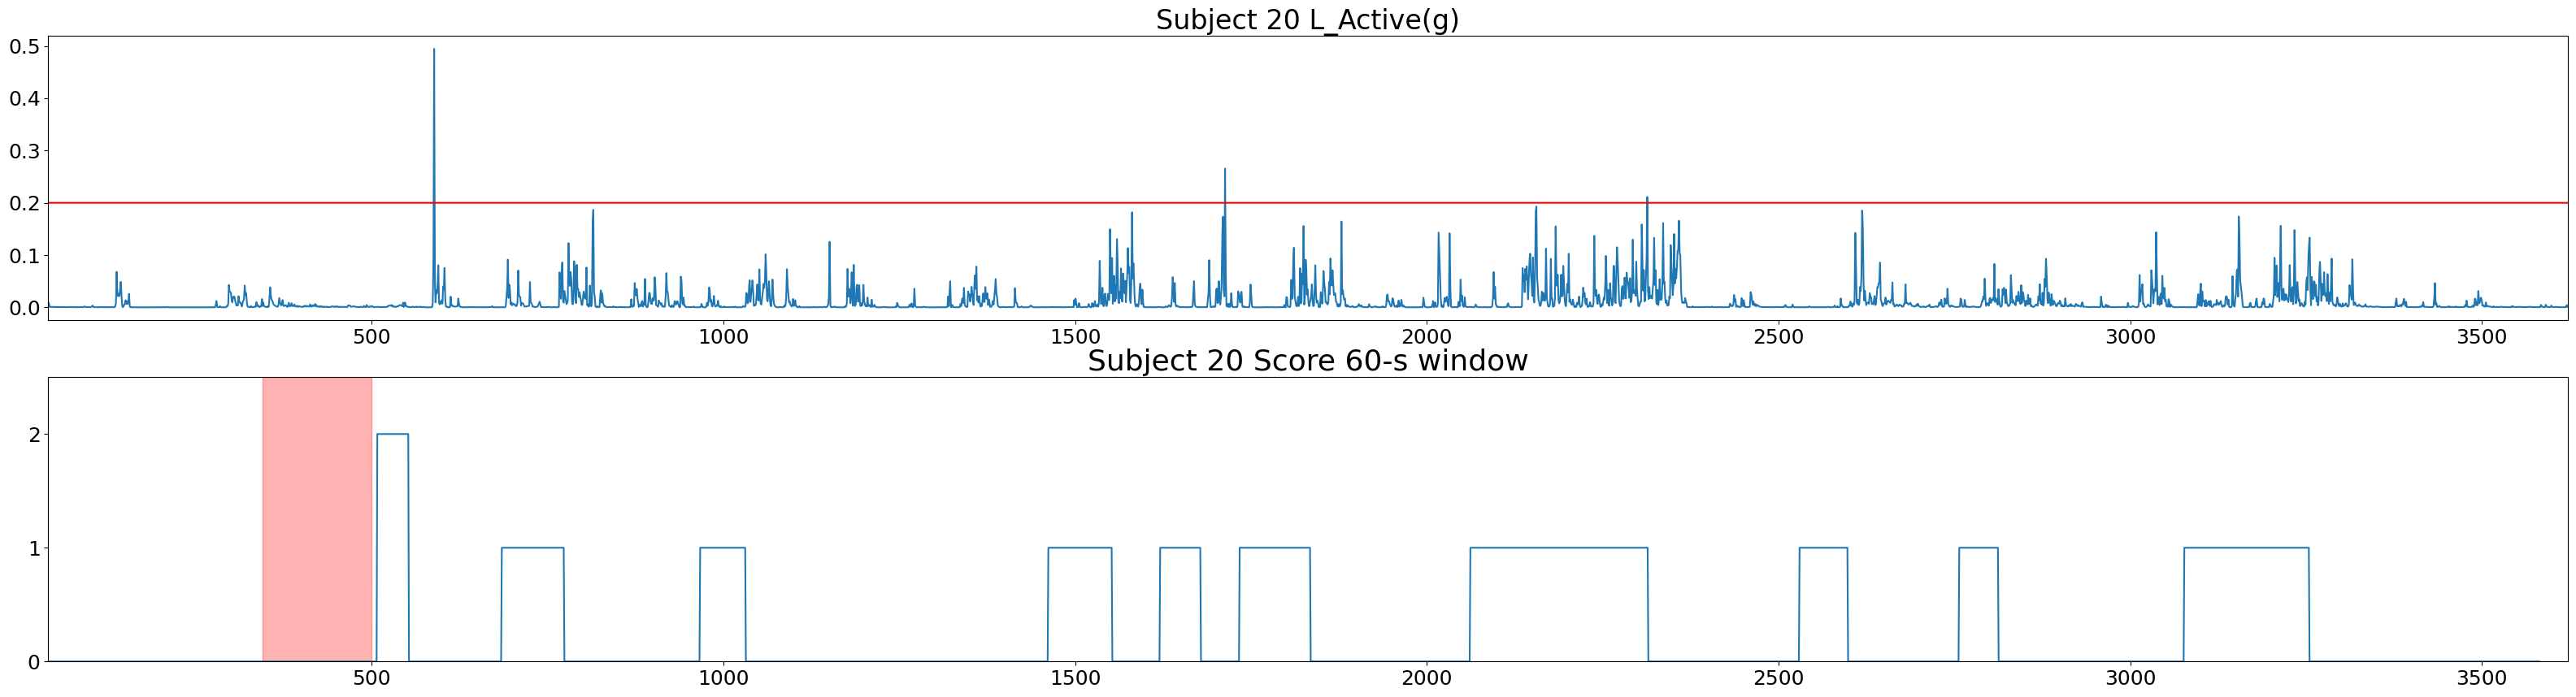

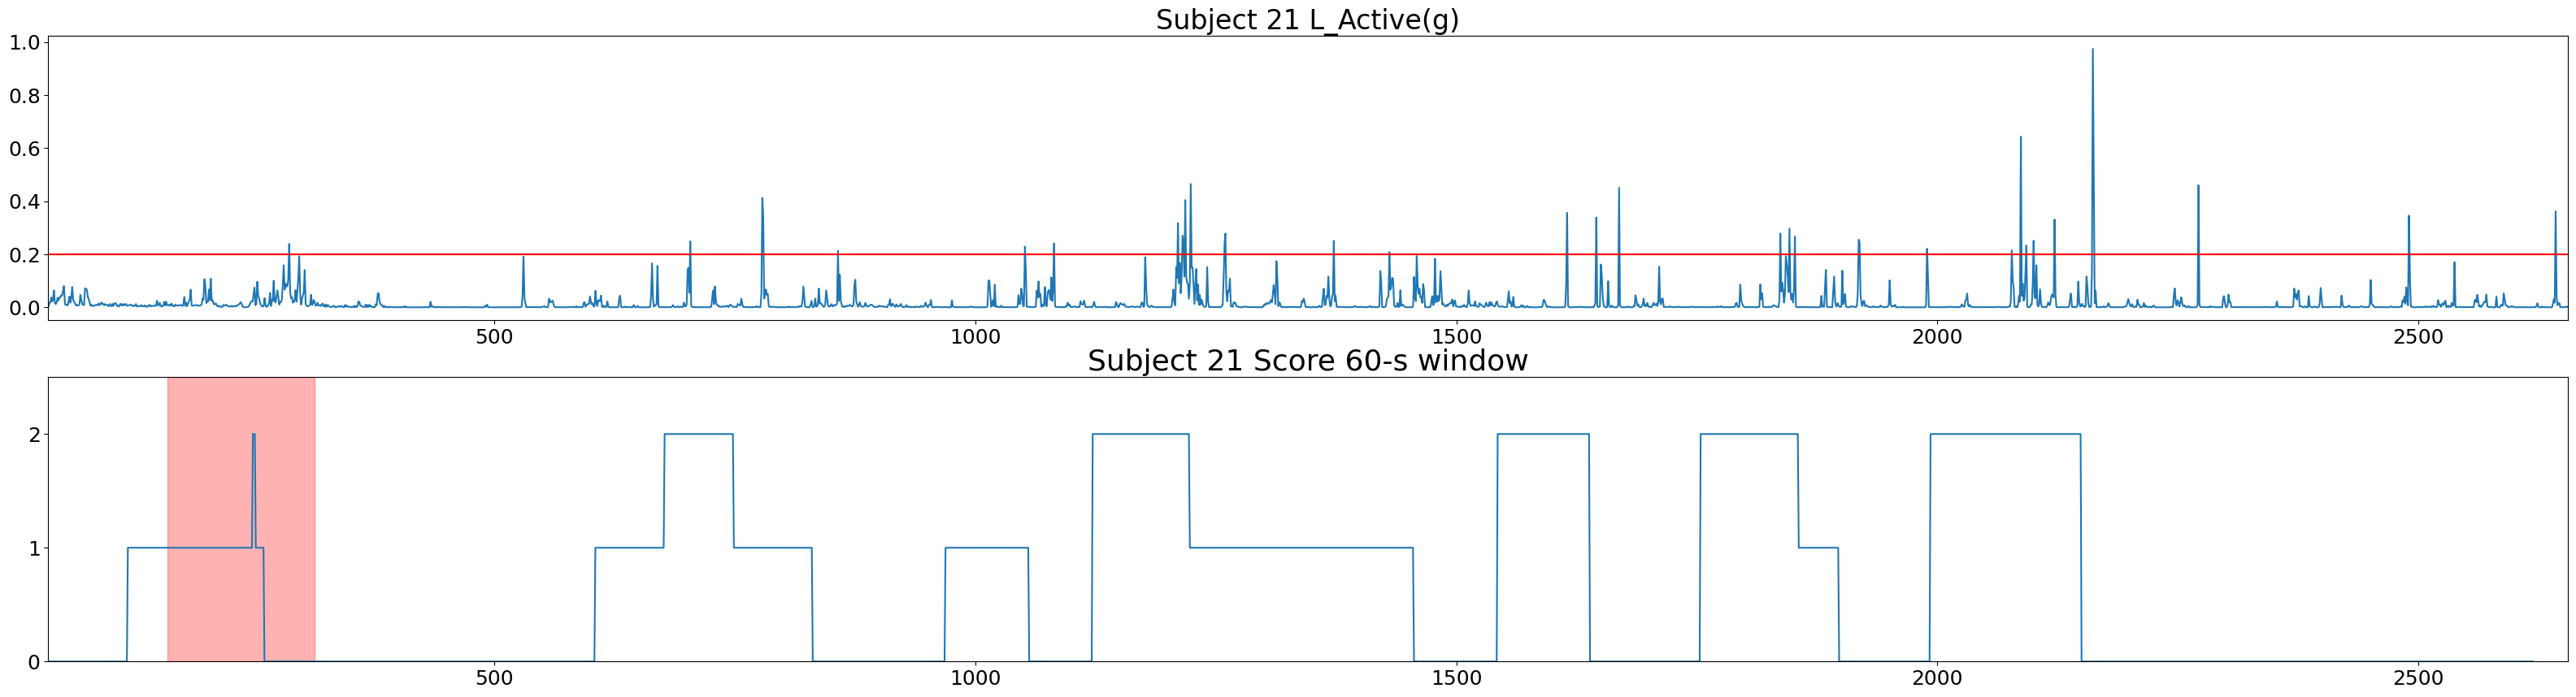

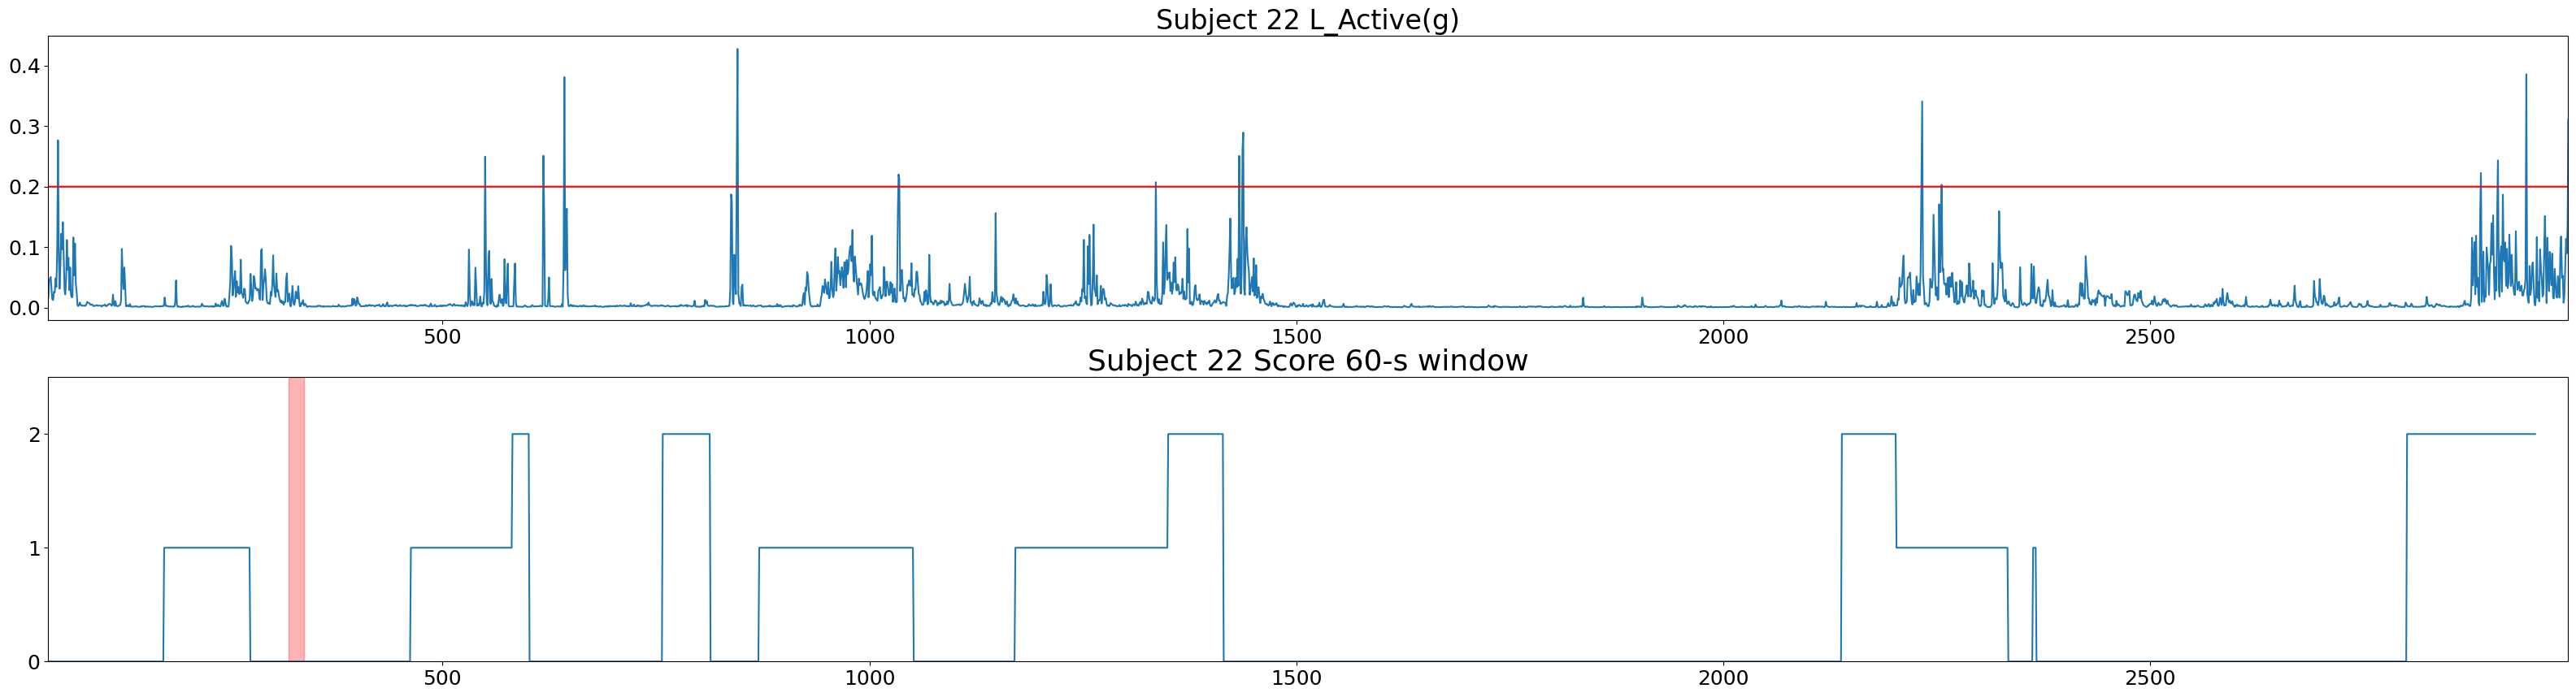

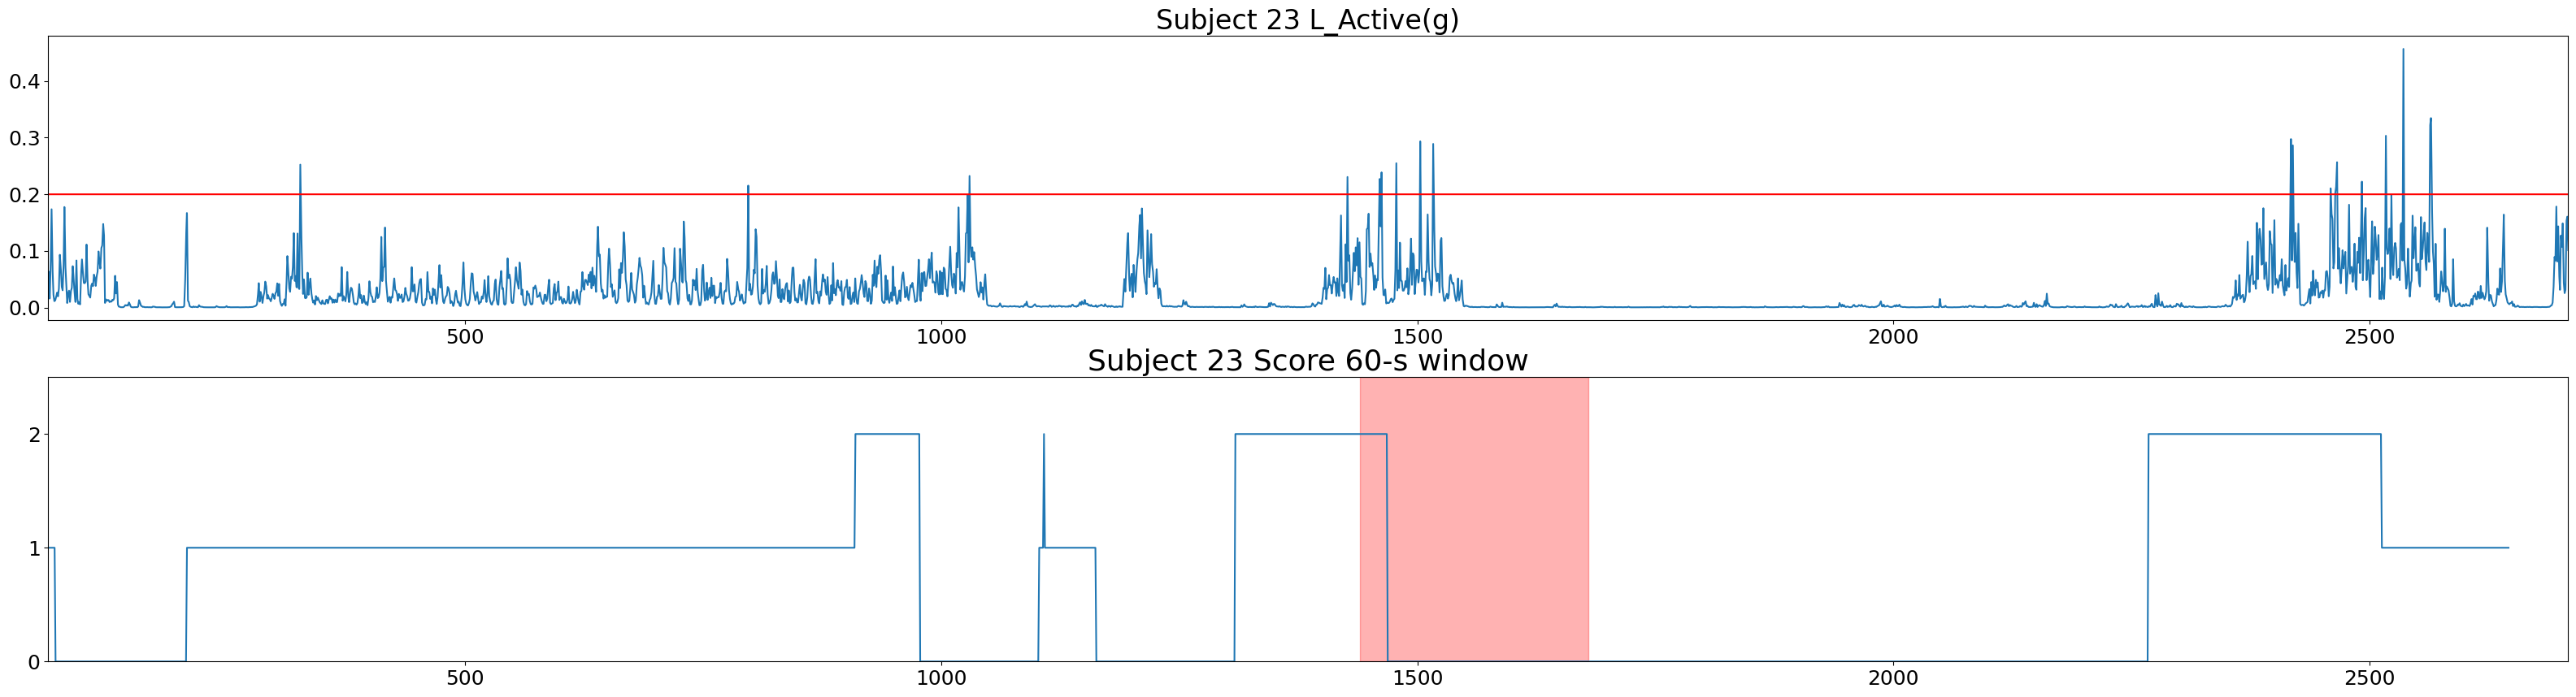

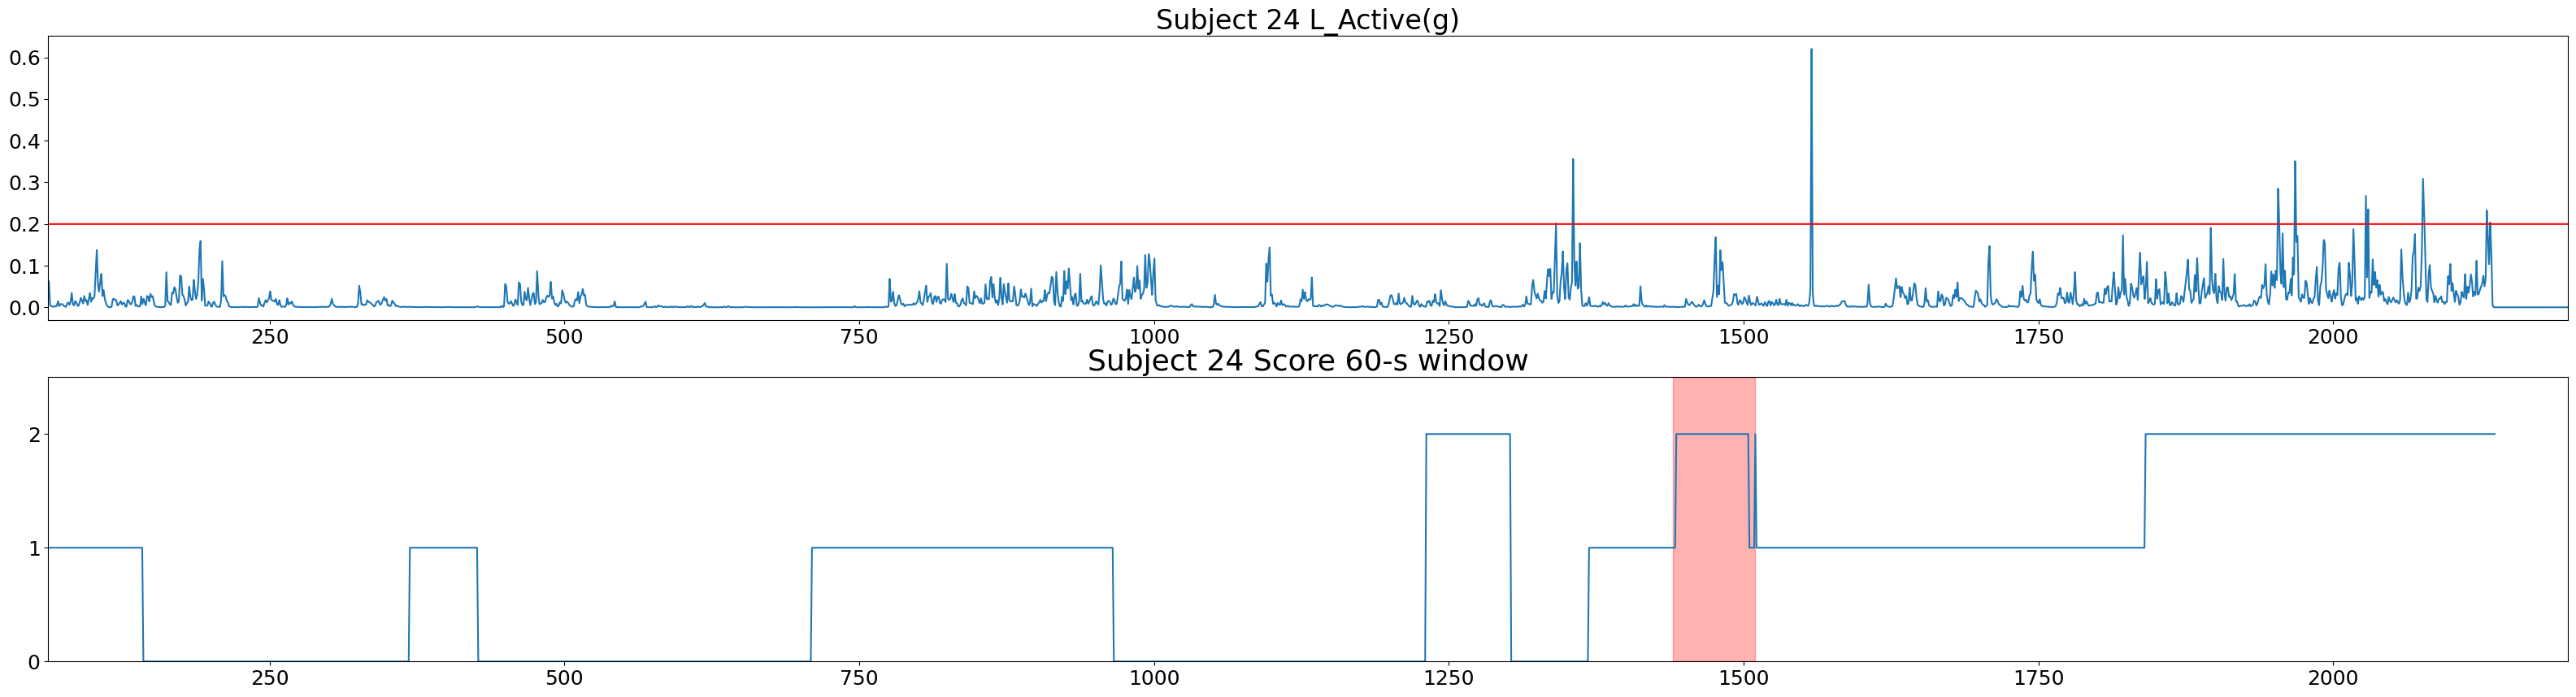

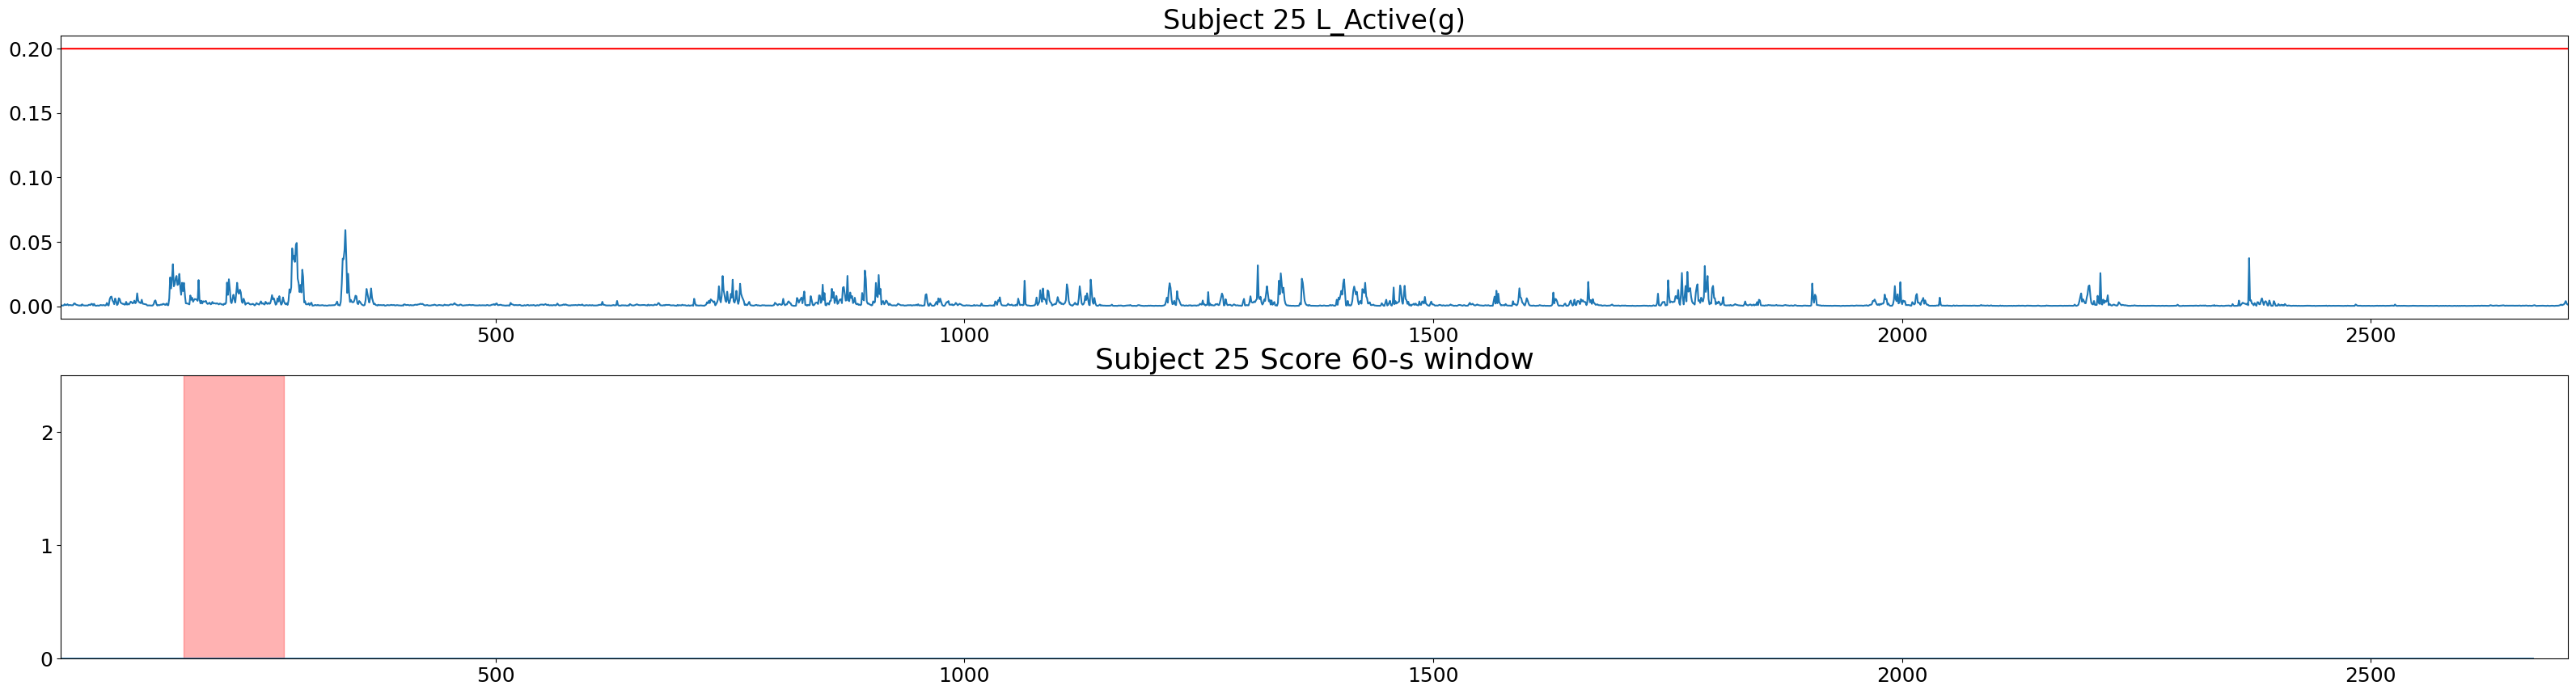

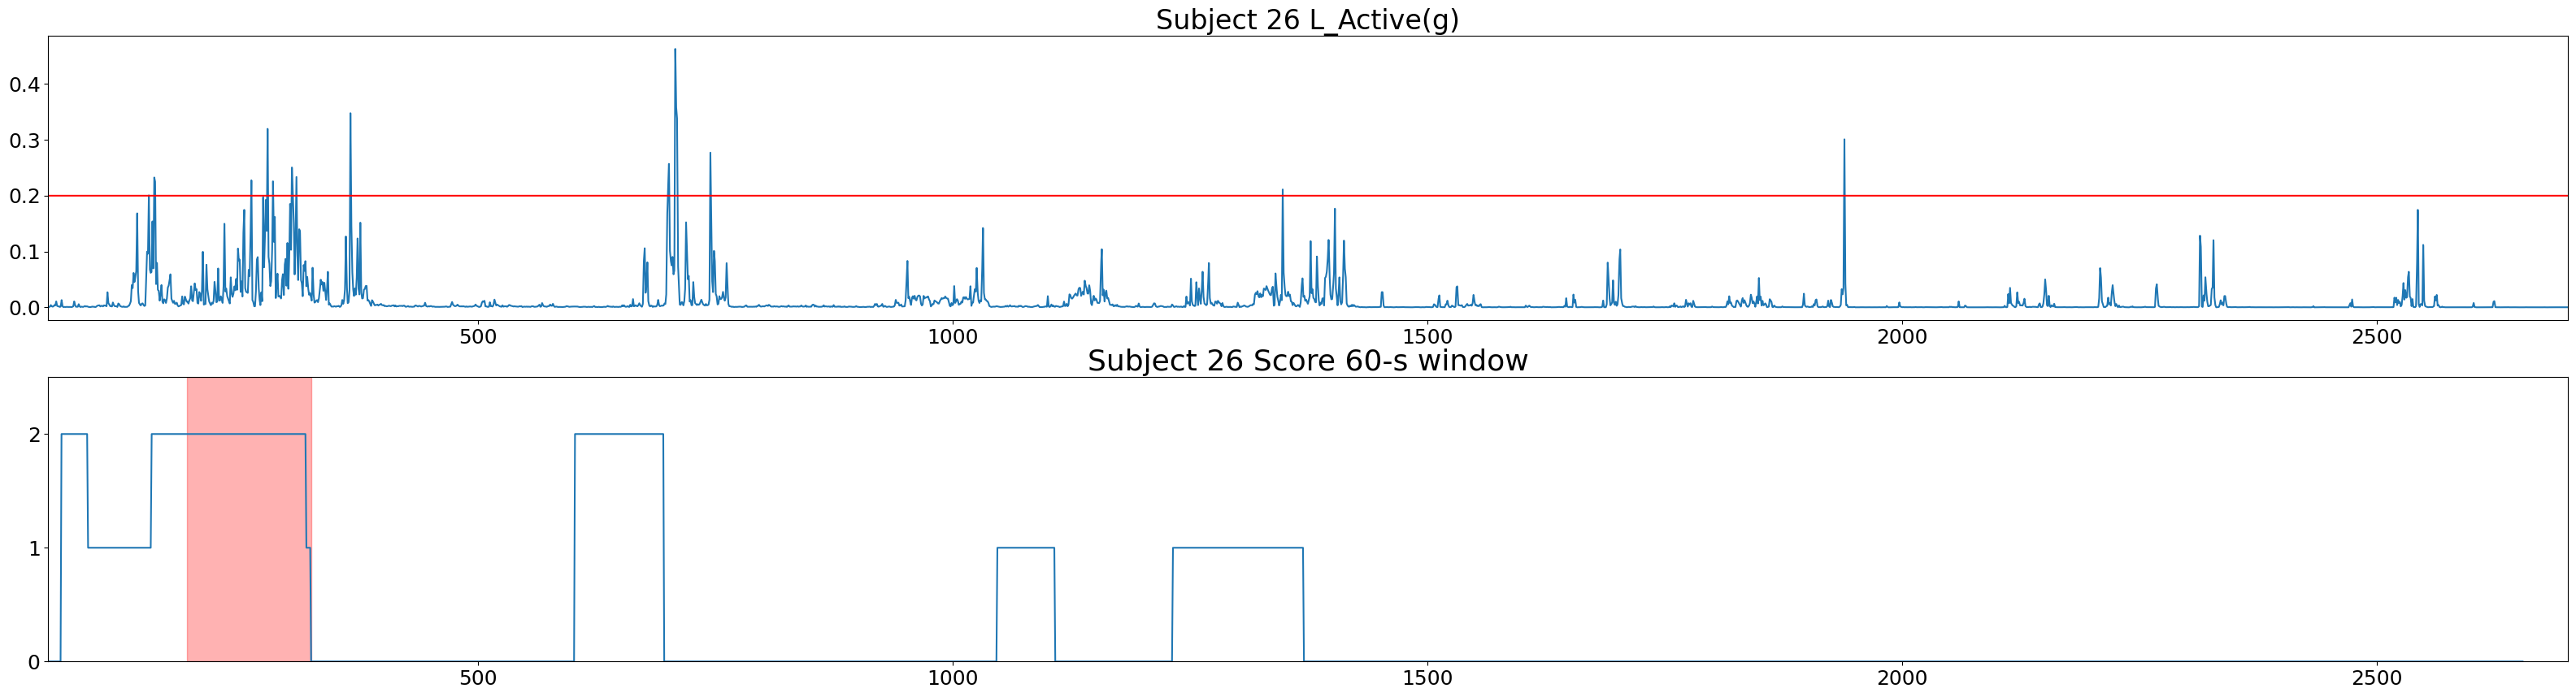

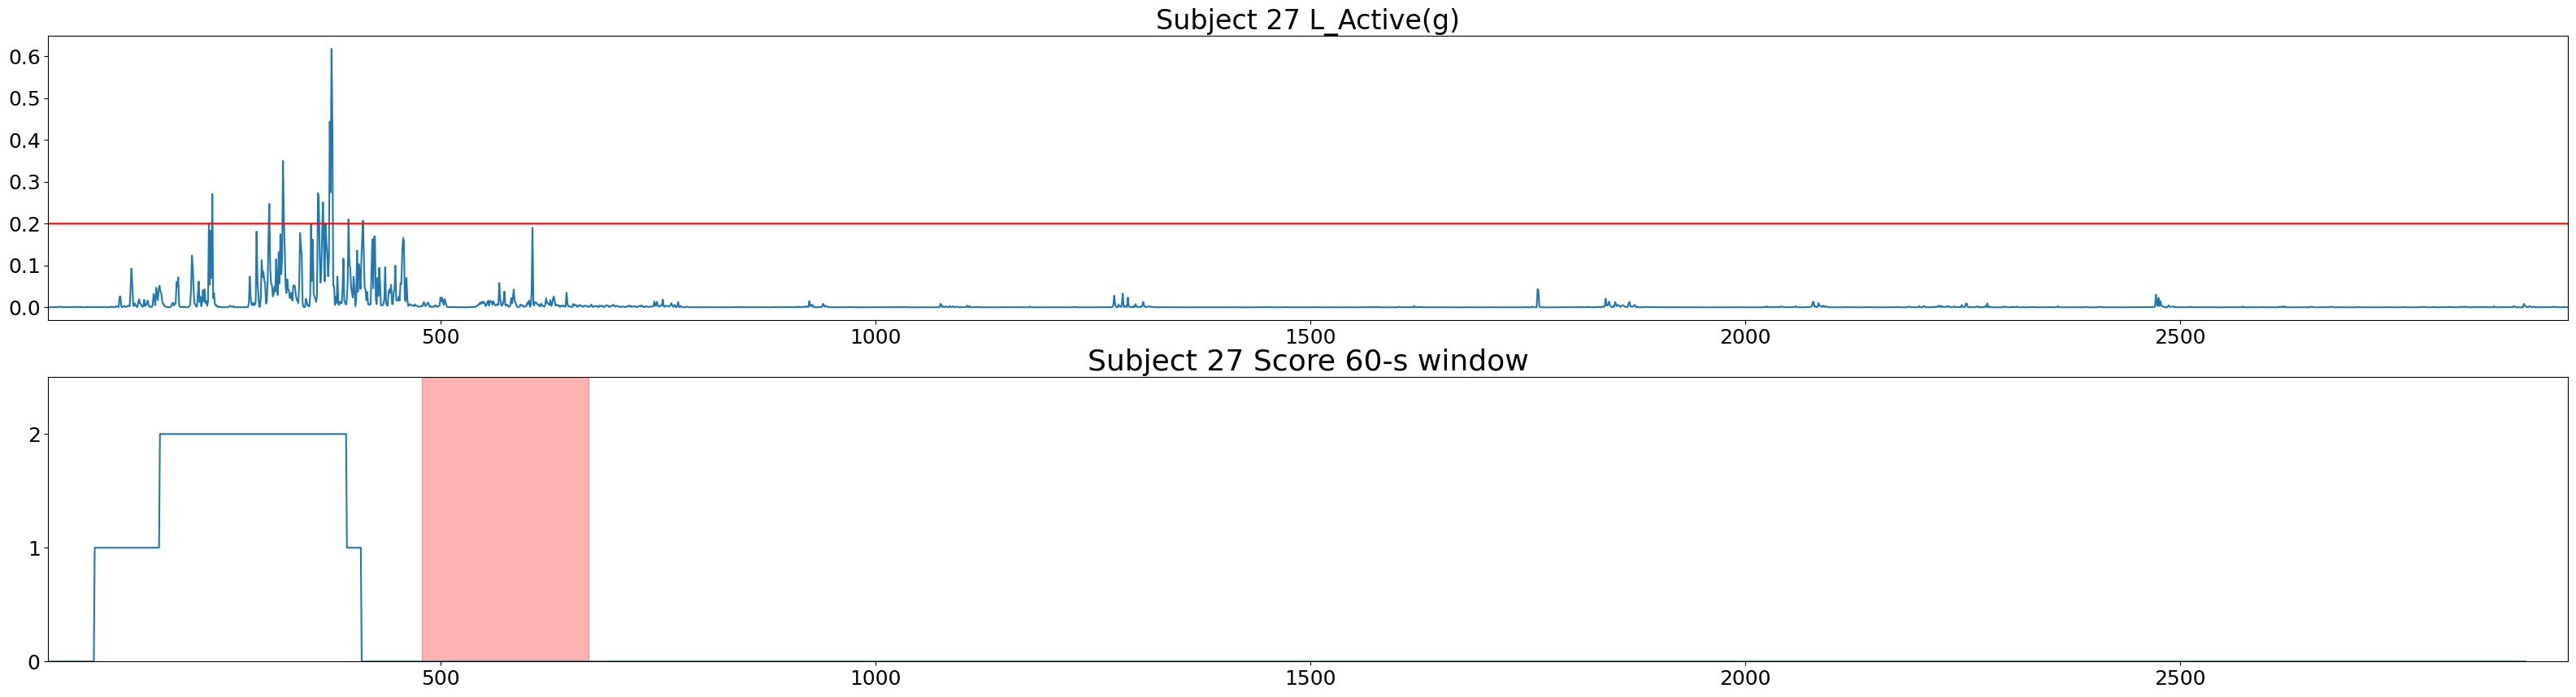

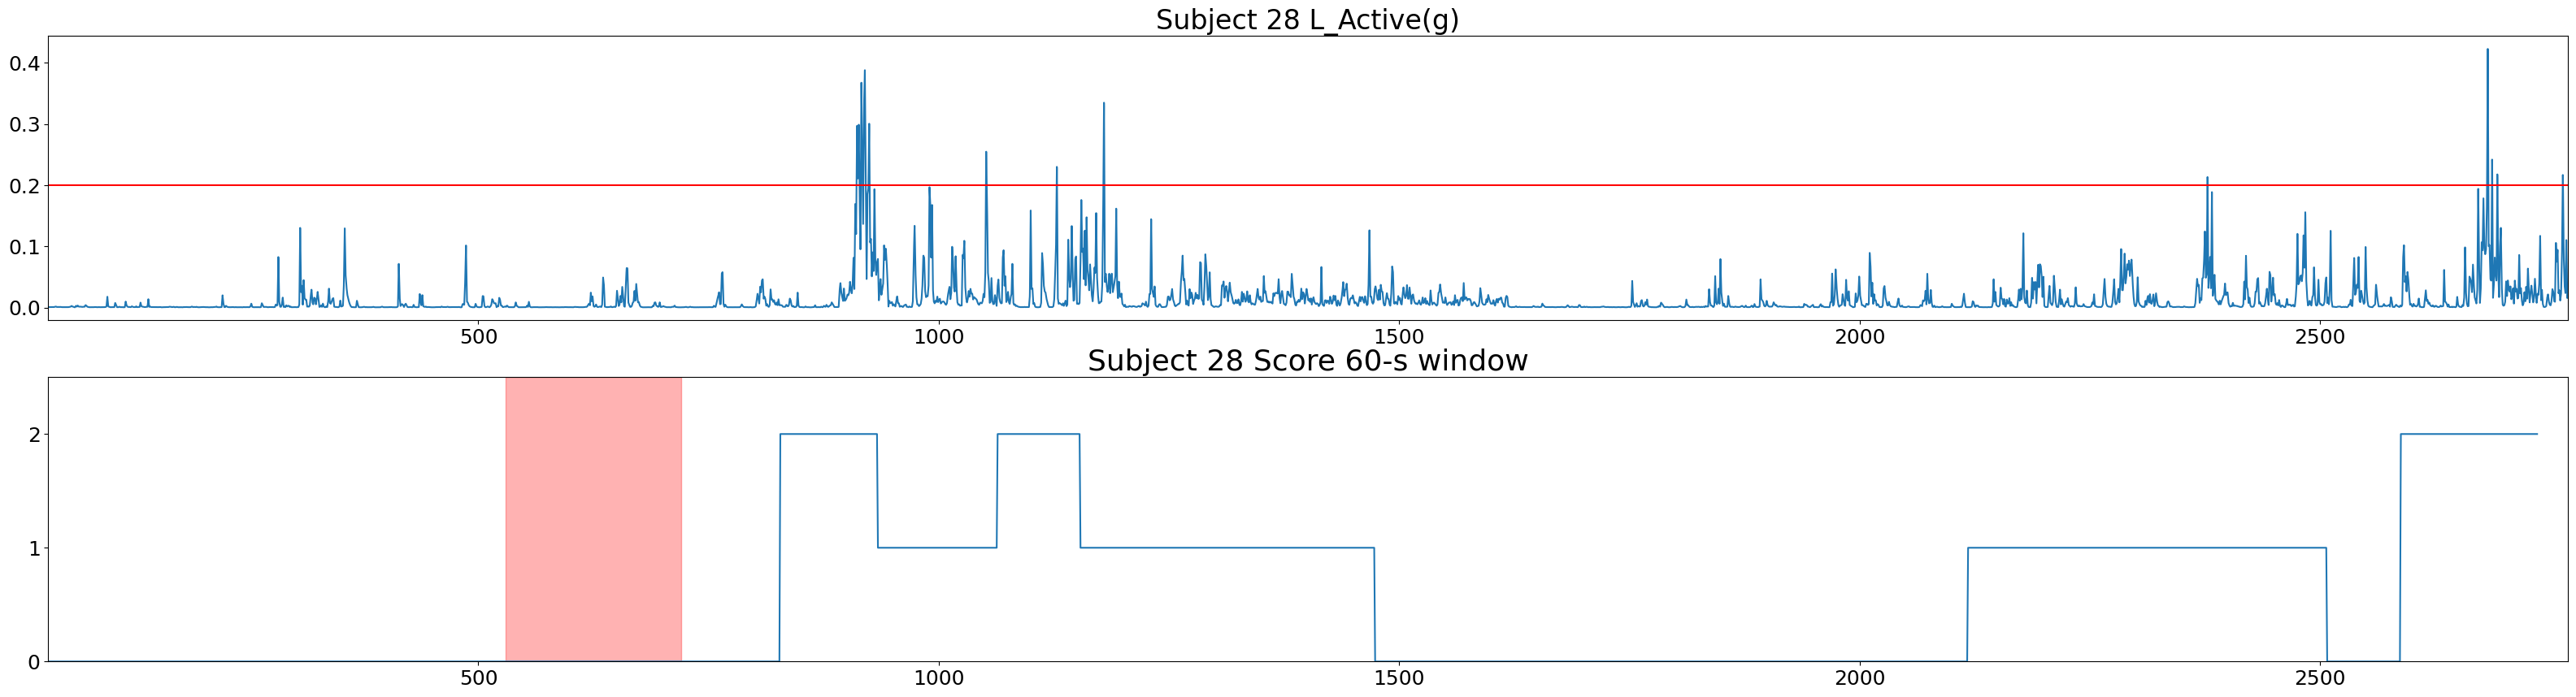

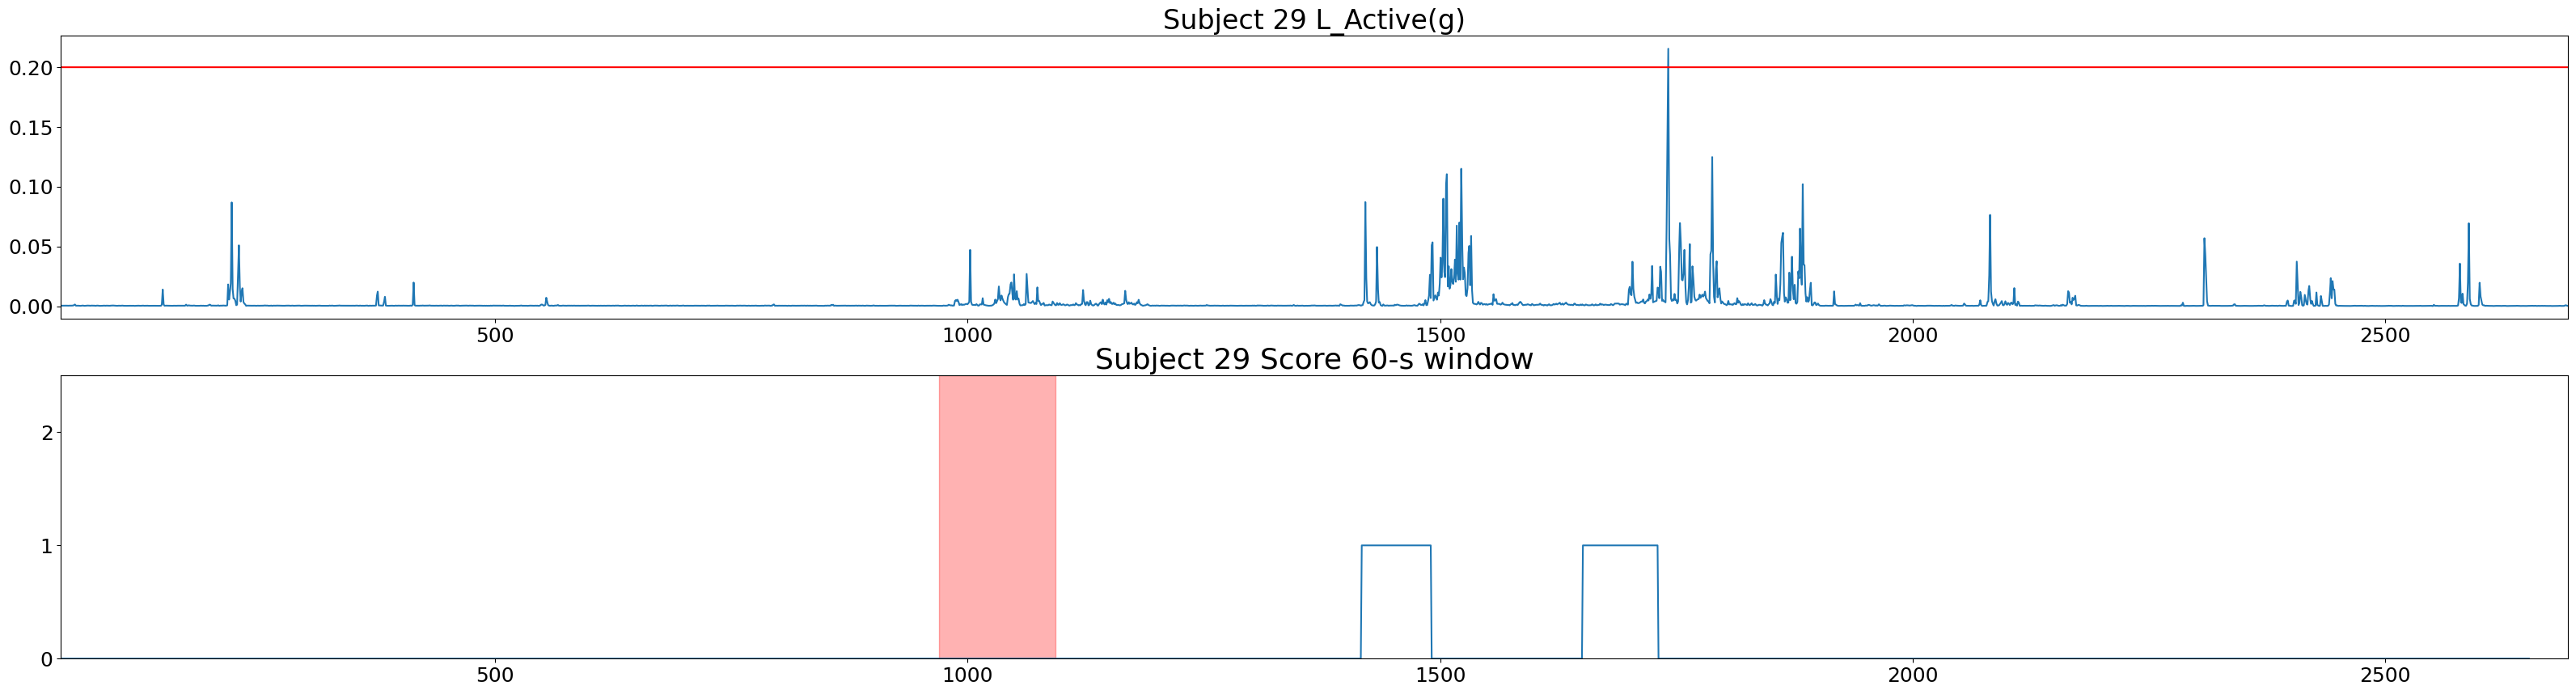

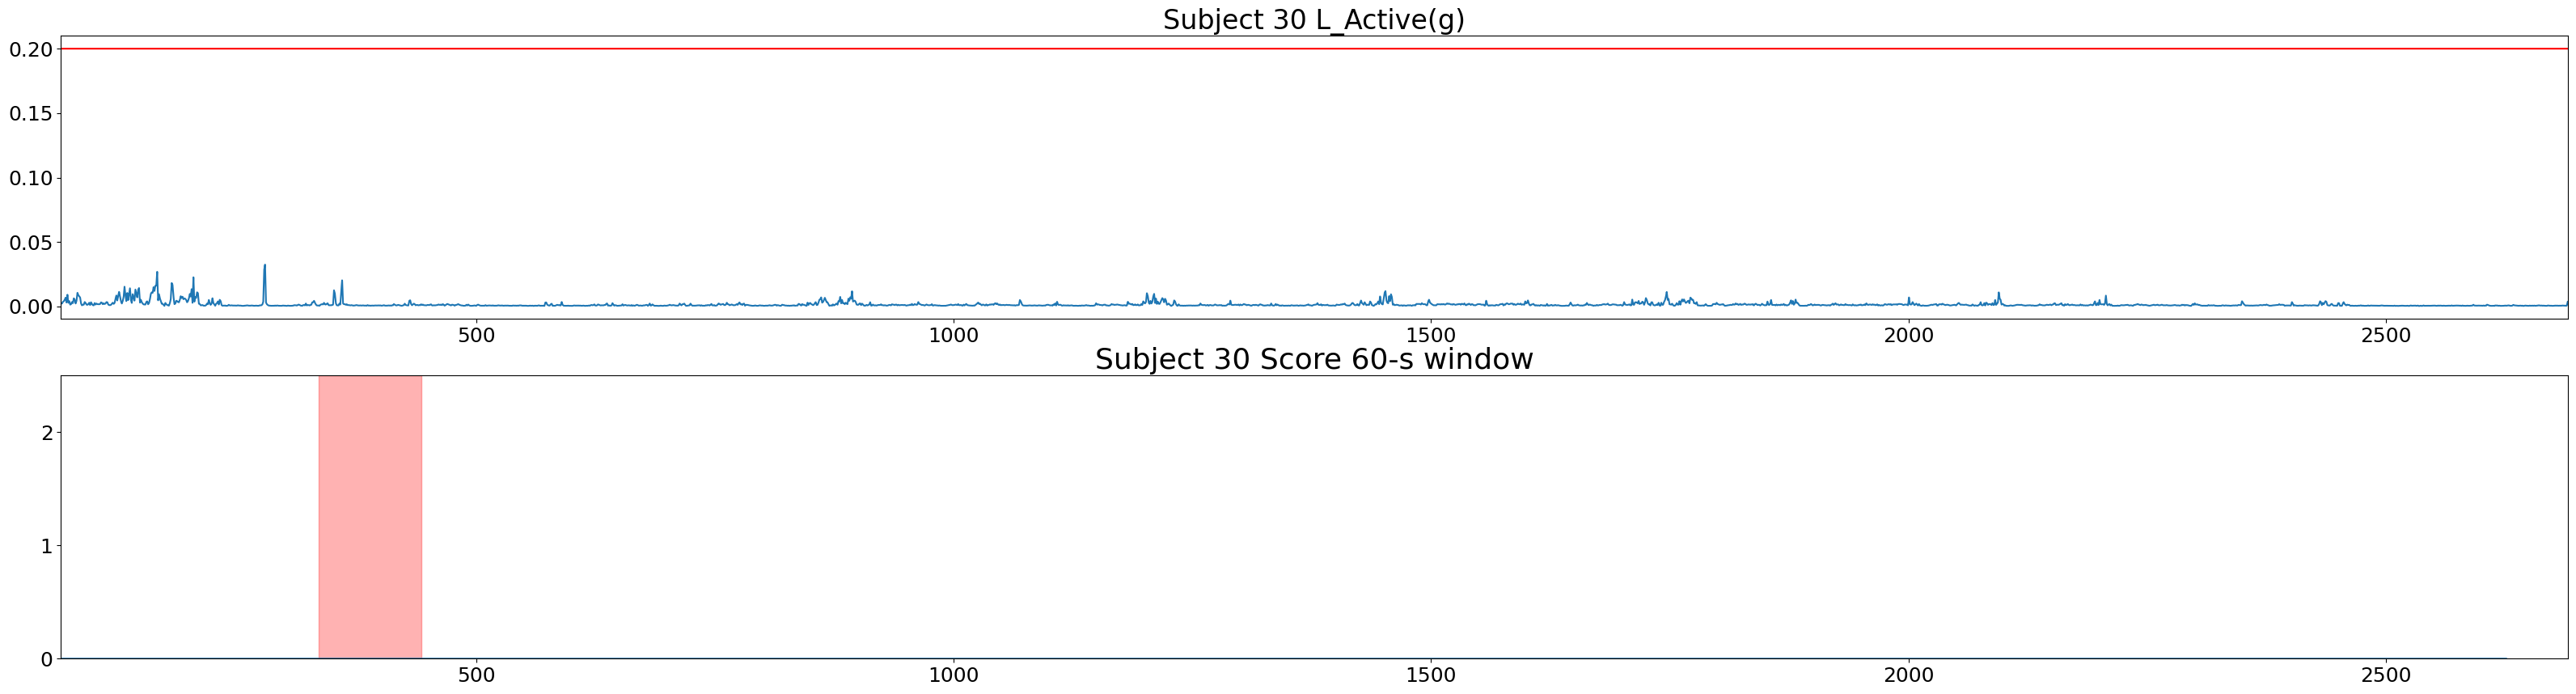

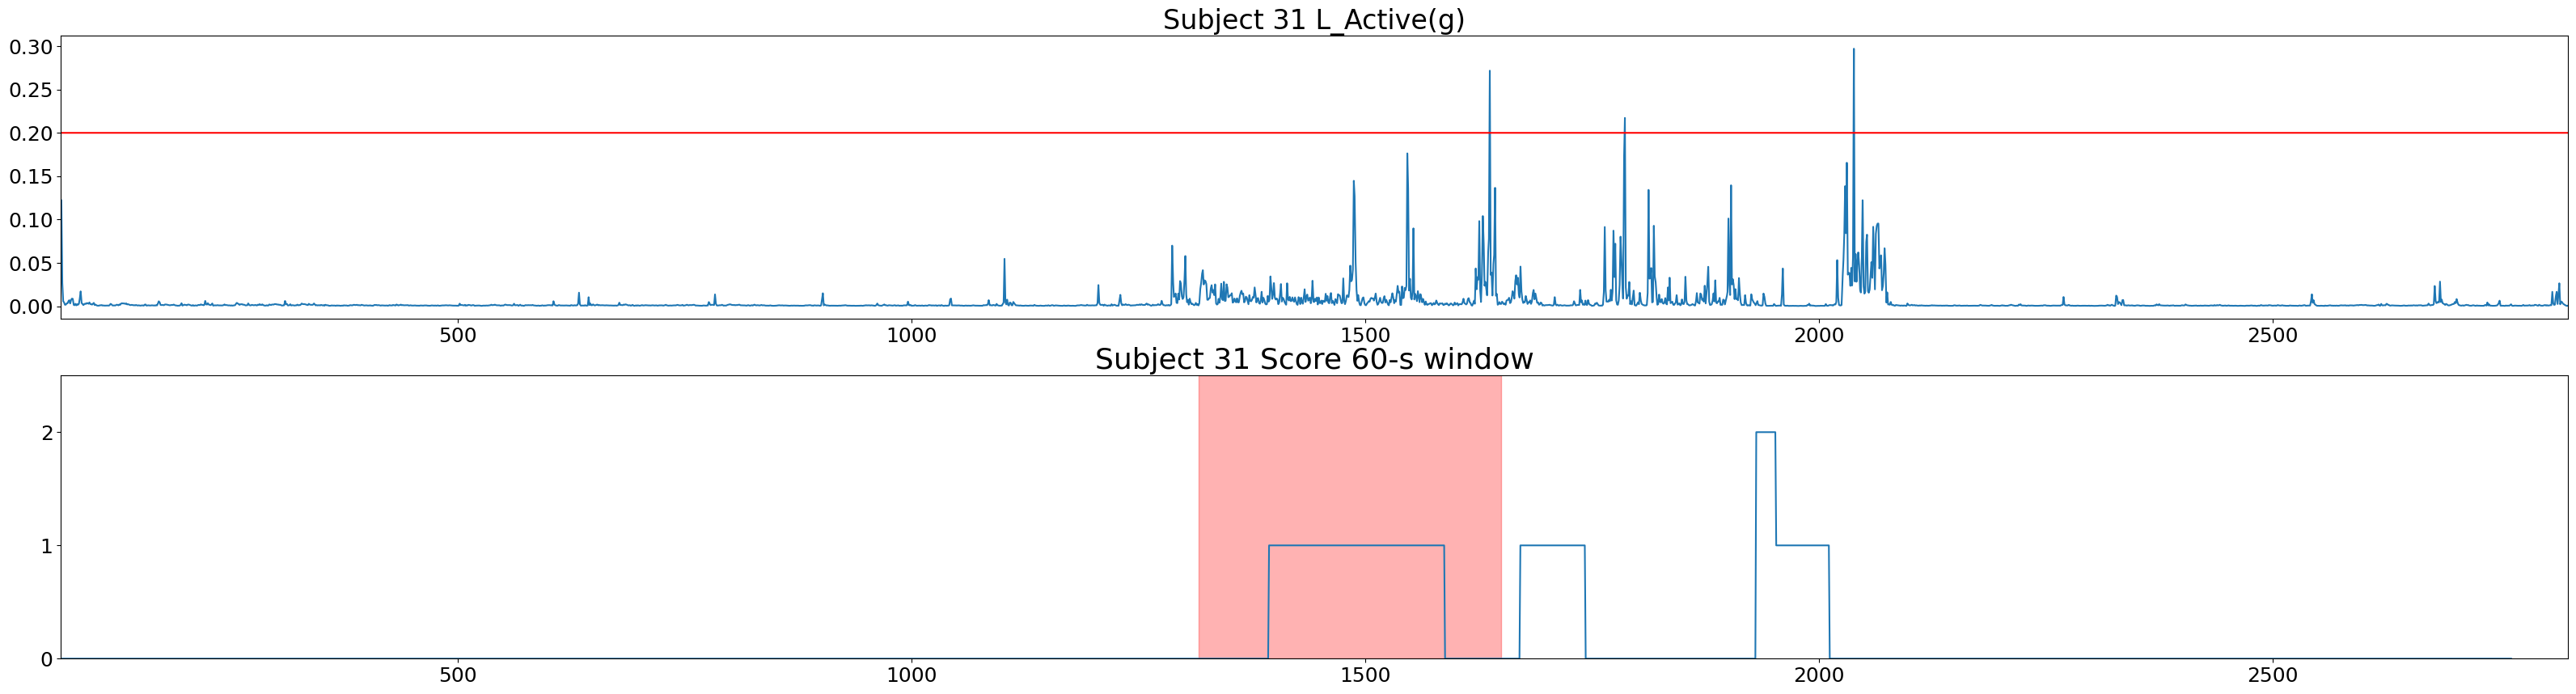

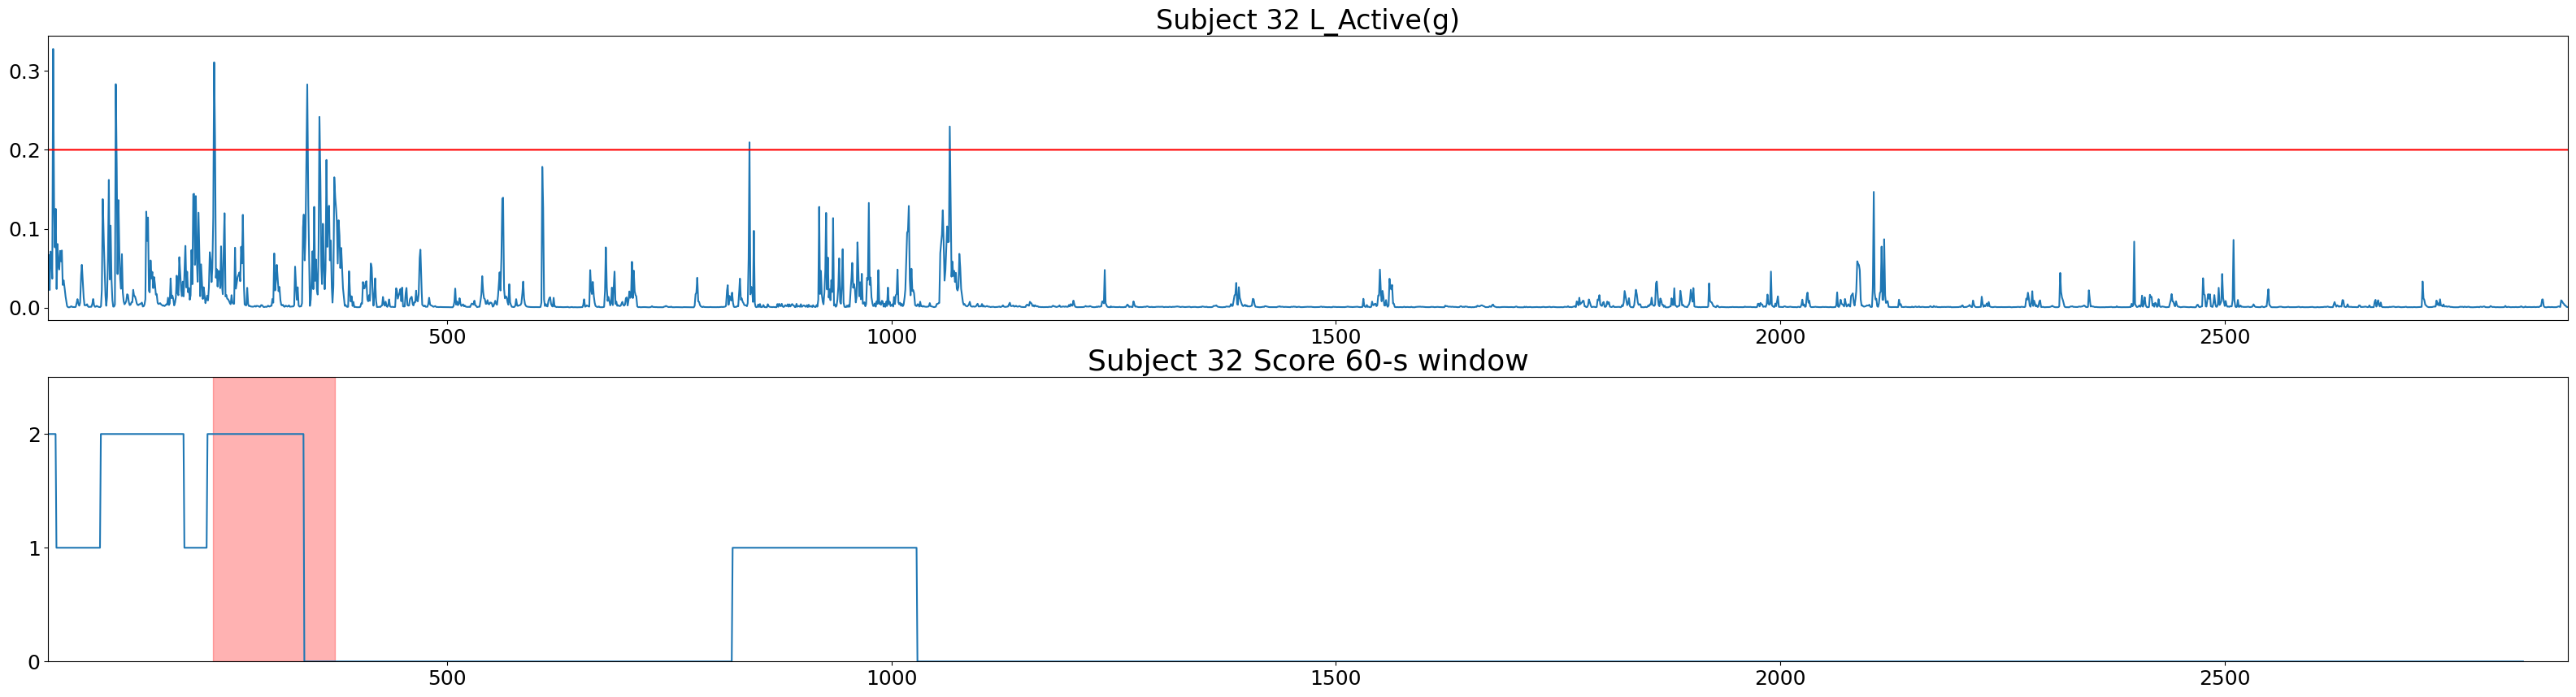

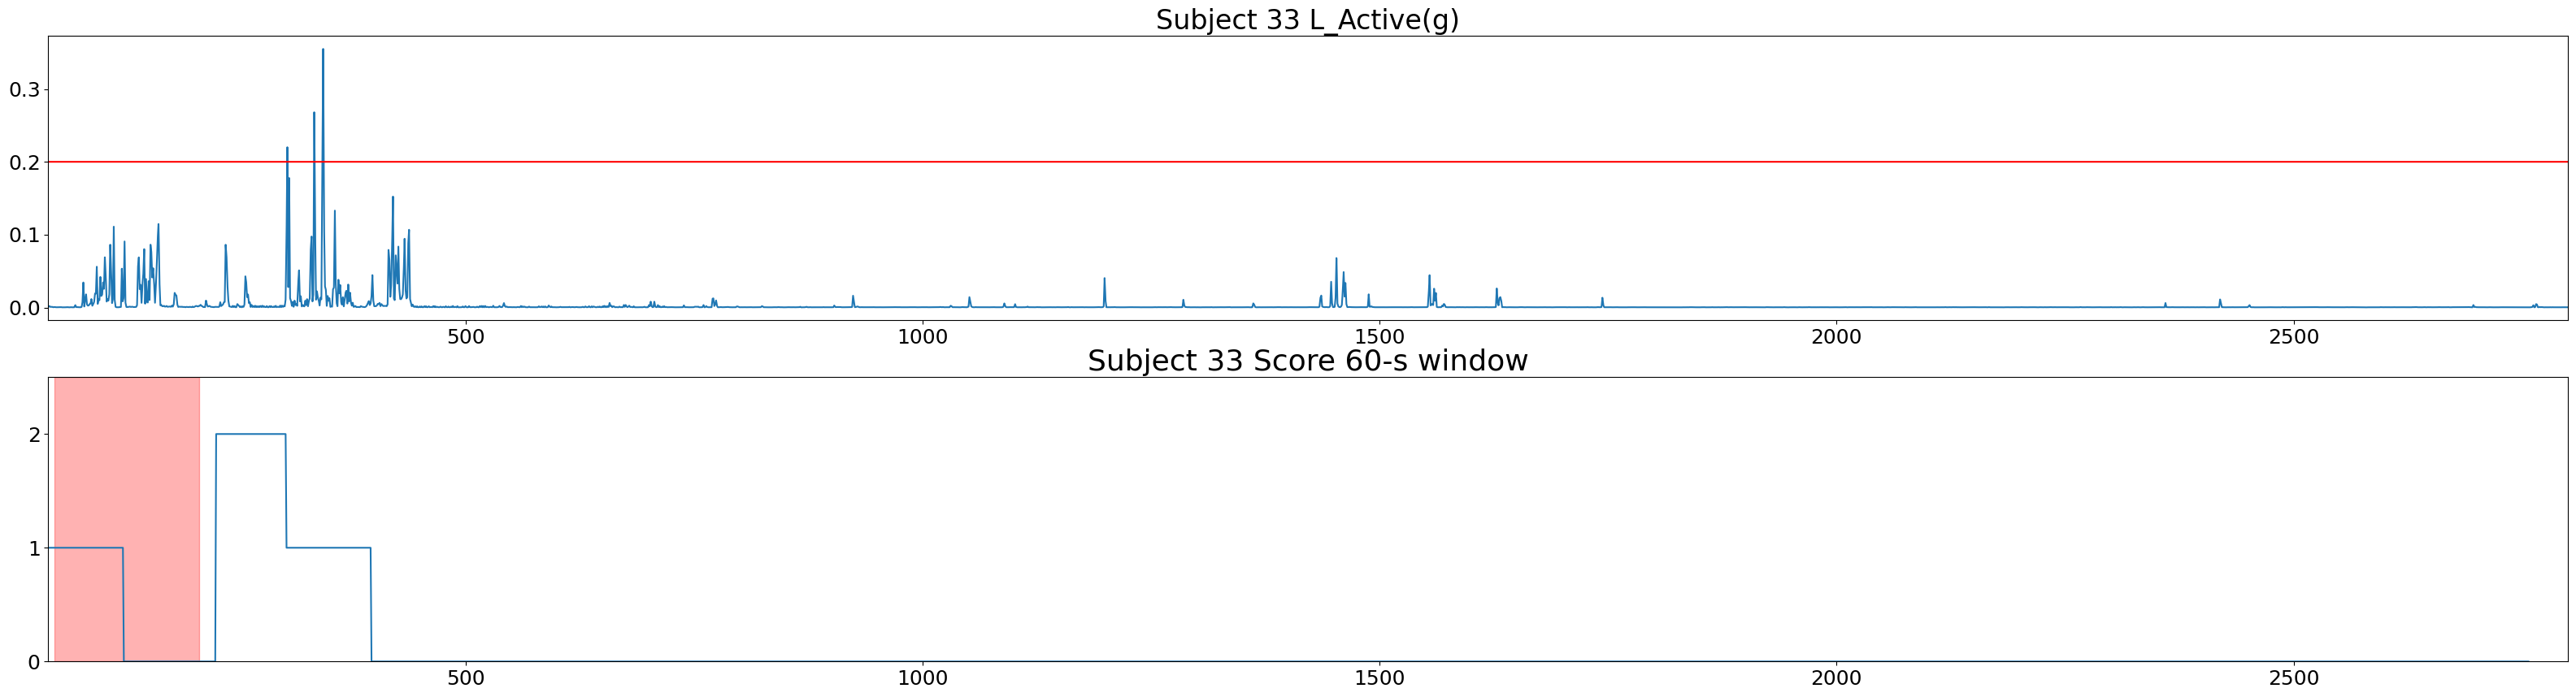

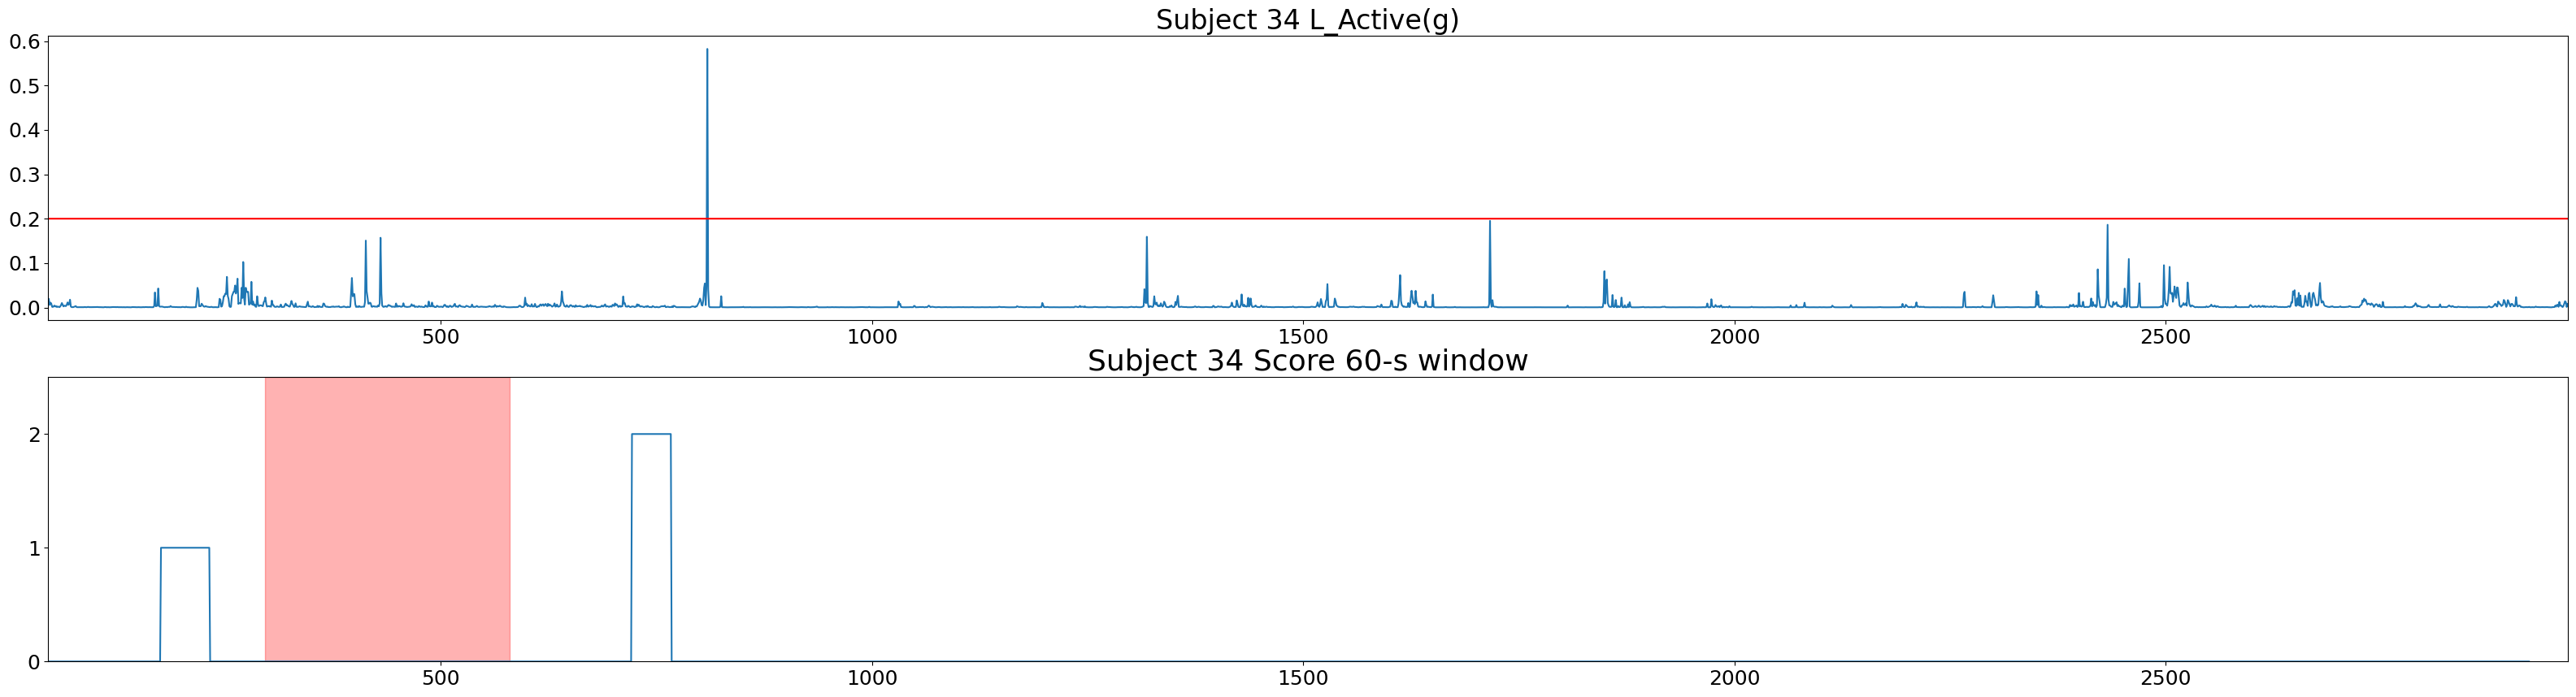

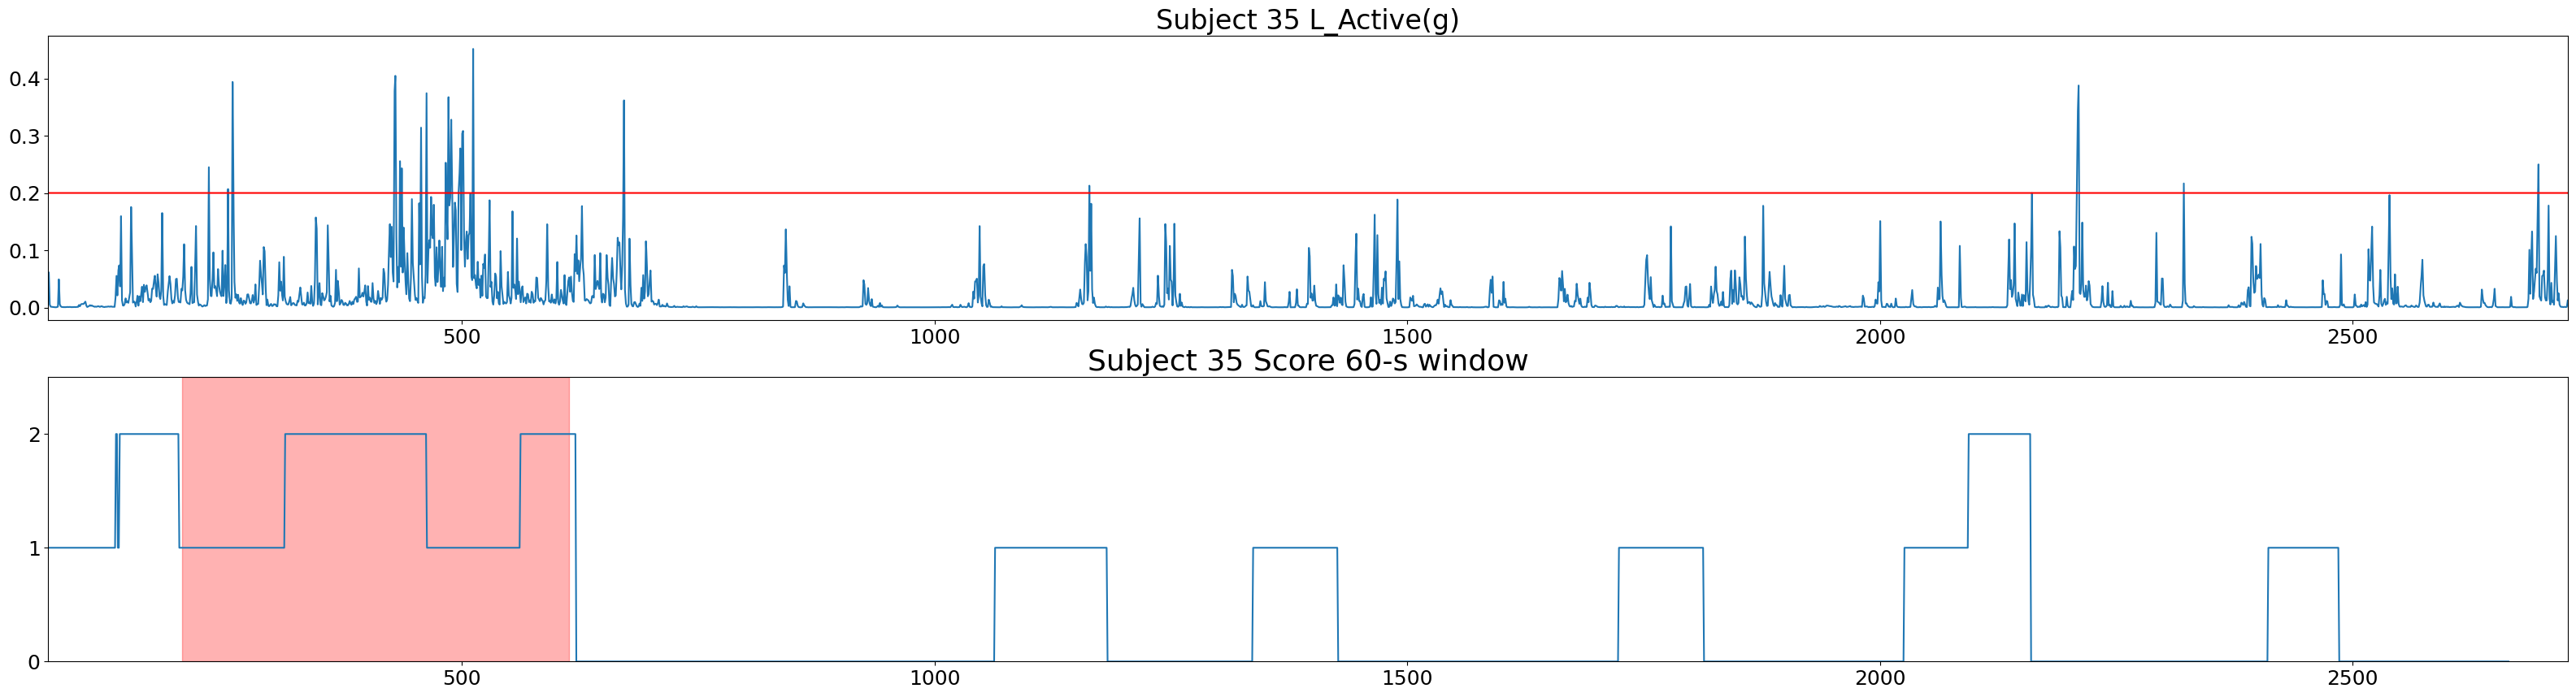

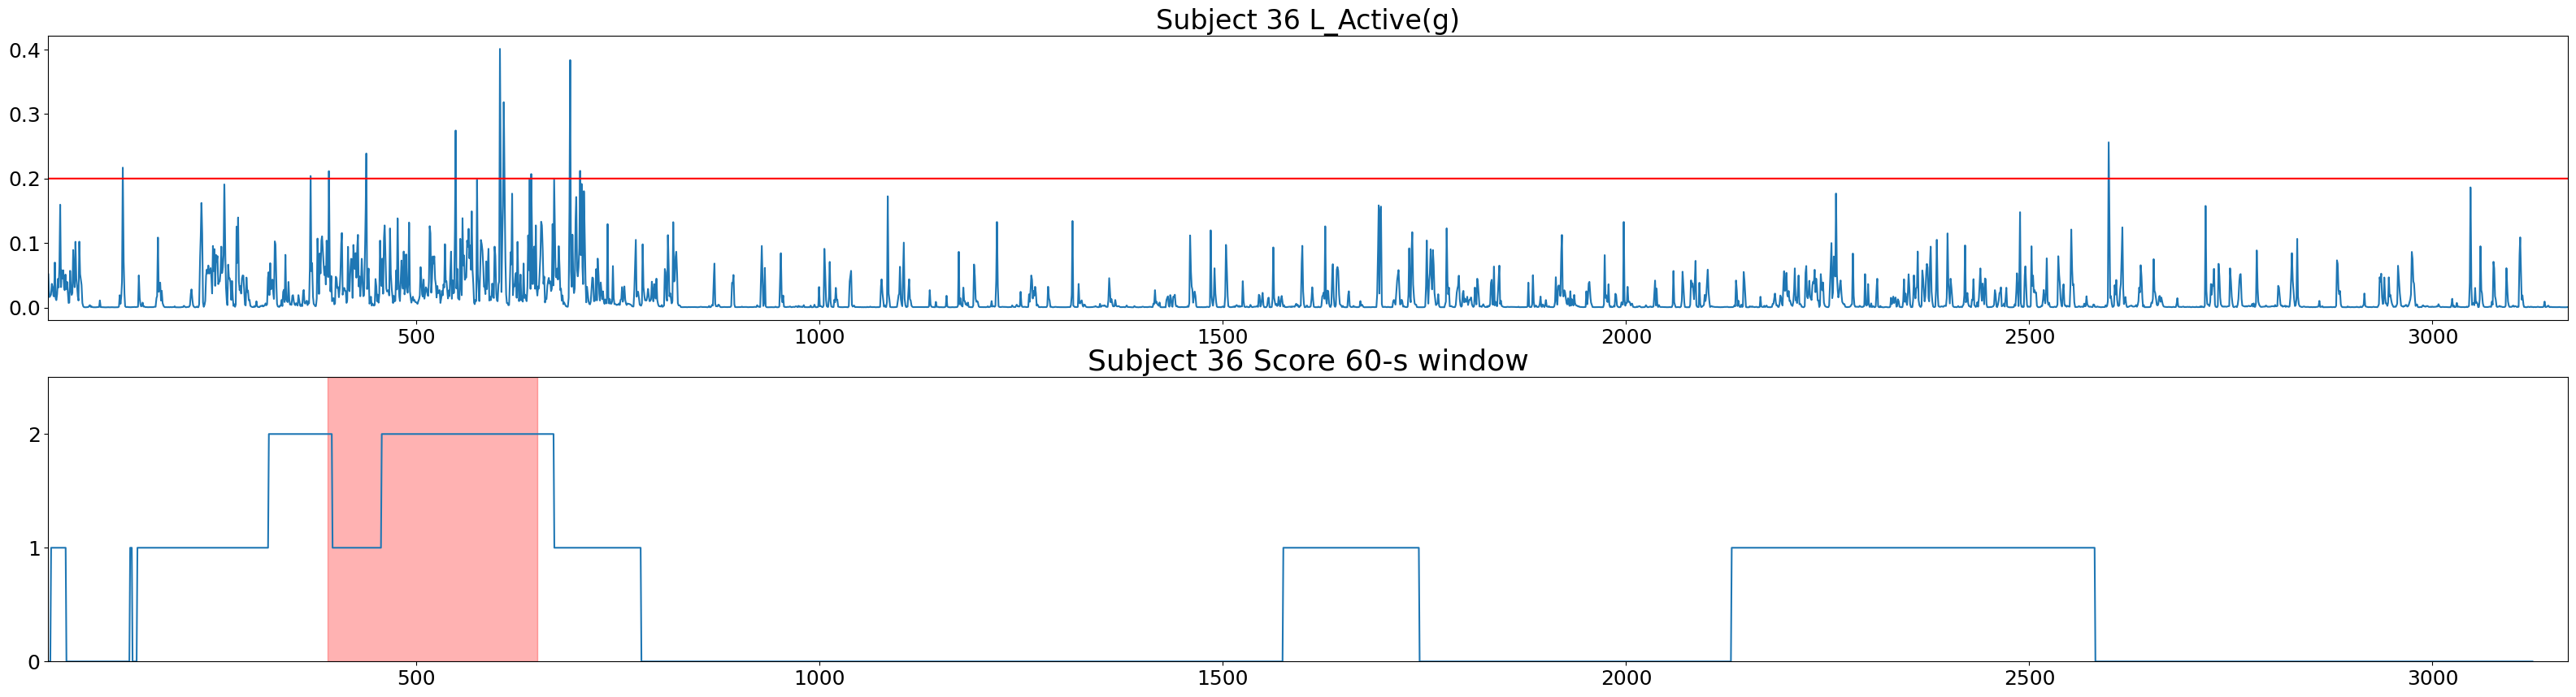

In [3]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Load the model and scaler
clf = np.load('svm_model.npy', allow_pickle=True).item()
scaler = np.load('scaler.npy', allow_pickle=True).item()

def rolling_apply(window):
    if len(window) == 600:
        # Reshape window for scaler and prediction
        window_reshaped = window.values.reshape(1, -1)
        window_scaled = scaler.transform(window_reshaped)
        prediction = clf.predict(window_scaled)
        return prediction[0]
    else:
        return np.nan

plt.rcParams['axes.titlesize'] = 26
plt.rcParams['xtick.labelsize'] = 26 
plt.rcParams['ytick.labelsize'] = 26 

for i in range(1, 37):
    if i == 11: continue
    results = get_data(i)
    s = results['lab_draw_start']
    e = results['lab_draw_end']
    data_df = results['data_df']


    score = data_df['L_Active(g)'].rolling(600, step=10).apply(rolling_apply)
    score = score.fillna(0).values
    score = apply_majority_voting(score)



    fig, axs = plt.subplots(2, figsize=(40, 10))
    axs[0].set_title(f'Subject {i} L_Active(g)', fontsize=24)


    axs[0].plot(data_df.index, data_df['L_Active(g)'].values.flatten())
    axs[0].plot(data_df.index, [0.2]*len(data_df), c='r')


    axs[1].plot( score)
    axs[1].set_ylim(0, 2.5)


    axs[1].axvspan(s, e, color='red', alpha=0.3)


    axs[0].tick_params(axis='both', which='major', labelsize=18)
    axs[1].tick_params(axis='both', which='major', labelsize=18)

    axs[0].set_xlim(data_df.index[0], data_df.index[-1])
    axs[1].set_xlim(data_df.index[0], data_df.index[-1])

    axs[1].set_title(f'Subject {i} Score 60-s window')

    axs[1].set_yticks([0, 1, 2])

    plt.show()


In [4]:
score

array([0, 0, 0, ..., 0, 0, 0])

In [5]:
data_df['L_Active(g)']

time(s)
43.539823      0.051489
43.639823      0.046855
43.739823      0.042221
43.839823      0.037586
43.939823      0.032952
                 ...   
3167.939800    0.000732
3168.039800    0.000749
3168.139800    0.000766
3168.239800    0.000783
3168.339800    0.000800
Name: L_Active(g), Length: 31249, dtype: float64